# **Importing Modules and Libraries**

In [2]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from os import path

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# **Importing Datasets**

In [2]:
# import os
# from google.colab import drive

# Mount Google Drive
# drive.mount('/content/gdrive')
# os.chdir('/content/gdrive/MyDrive/Papi')
!wget "https://drive.google.com/uc?export=download&id=1cPlyRYexAZPZv8r2vPOfNmapgdiBYnb_" -O "UNSW_NB15.csv"

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
#data = pd.read_csv('/content/drive/MyDrive/IoT_ML_Dataset/UNSW/UNSW_NB15.csv')
df = pd.read_csv('UNSW_NB15.csv')

Sau dropna/dropdup: (175341, 47)


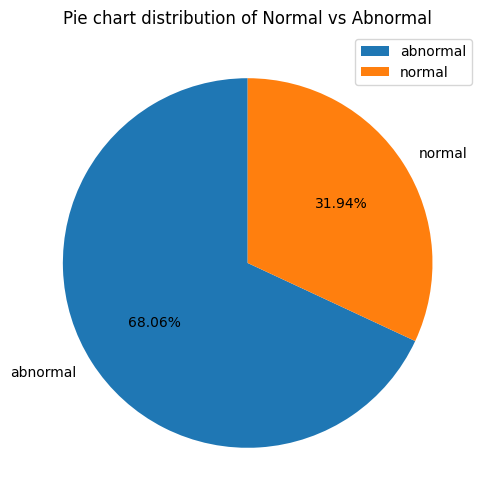

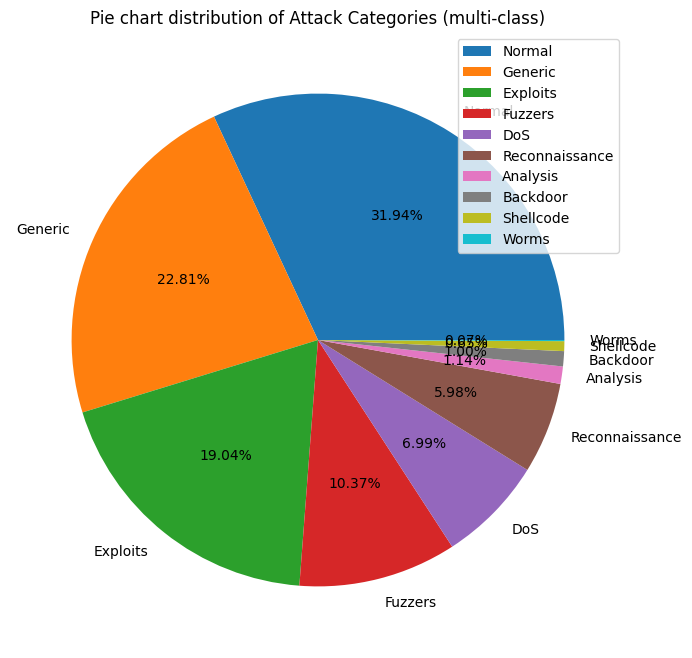

Số feature trước encode: 42
Categorical columns: ['proto', 'service', 'state']
Chọn theo ngưỡng |corr| >= 0.3: 11 features
Selected features: ['sttl', 'ct_state_ttl', 'state', 'dload', 'ct_dst_sport_ltm', 'dmean', 'rate', 'swin', 'dwin', 'ct_src_dport_ltm', 'ct_dst_src_ltm']


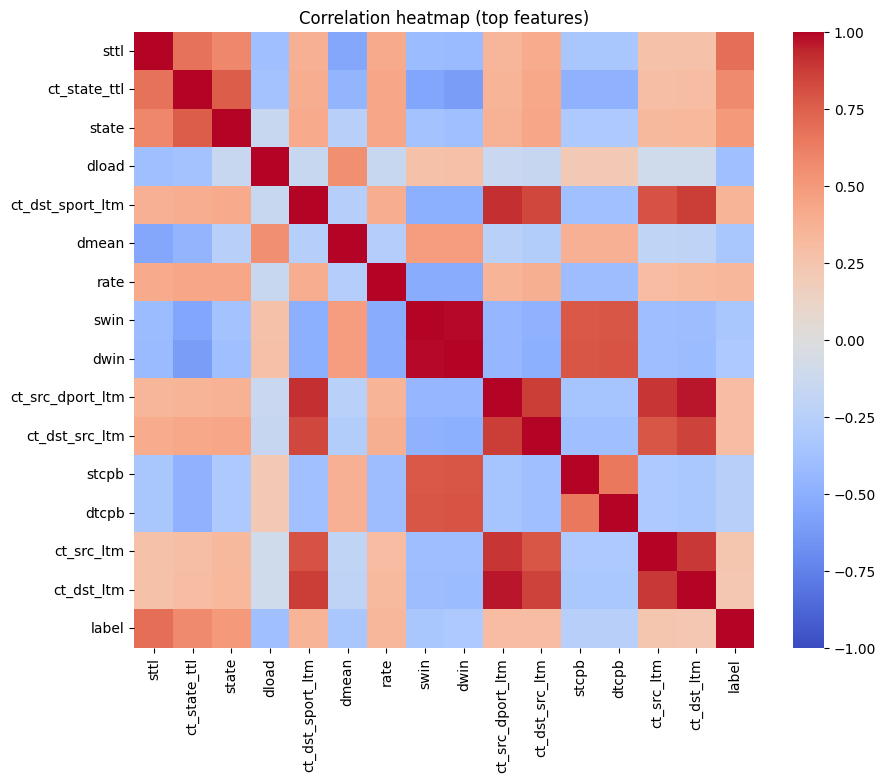

Dataset dùng để train: (10000, 11)
Train/Test sizes: (8000, 11) (2000, 11)
Tỉ lệ attack trong train: 0.680625

[RF baseline] time=1.316s, acc=0.9310
              precision    recall  f1-score   support

           0     0.8983    0.8842    0.8912       639
           1     0.9460    0.9530    0.9495      1361

    accuracy                         0.9310      2000
   macro avg     0.9221    0.9186    0.9203      2000
weighted avg     0.9308    0.9310    0.9309      2000



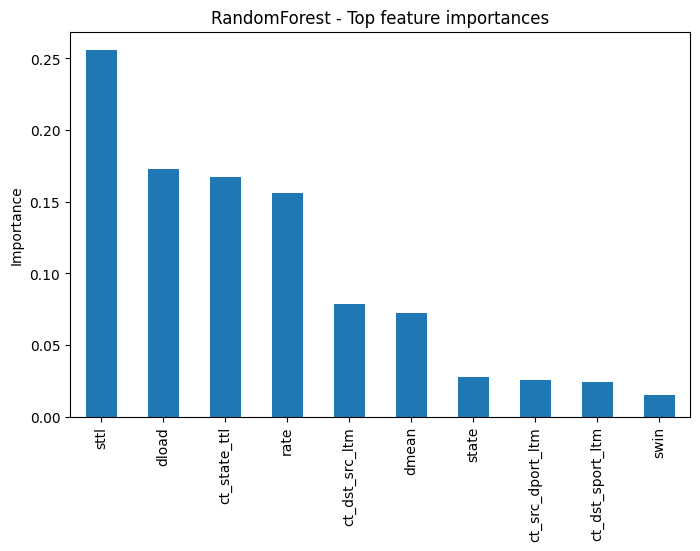

Tìm thấy TTL-like feature: sttl

[RF after occlusion] drop: sttl
time=1.193s, acc=0.9270
Accuracy giảm tuyệt đối: 0.0040000000000000036
Giảm theo %: 0.42964554242749764

Comparison summary:
DecisionTree: time=0.100s, acc=0.9170
RandomForest(50): time=0.740s, acc=0.9280


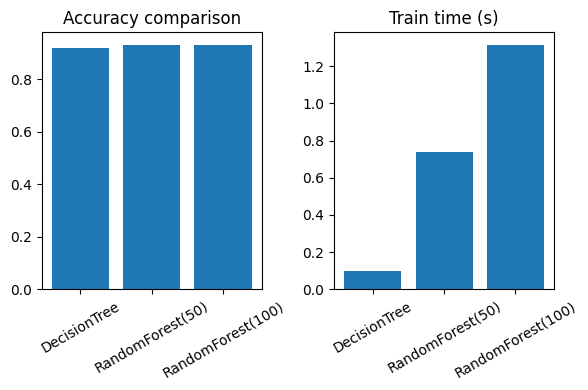


FINAL SUMMARY:
RF(100) acc=0.9310, time=1.316s
RF(50)  acc=0.9280, time=0.740s
DT      acc=0.9170, time=0.100s
RF after occlusion (drop sttl) acc=0.9270, time=1.193s


In [4]:
# Colab-ready: rút gọn theo base tác giả (binary only)
# Nội dung: preprocess, visuals (pie), feature selection (corr), 
# Kịch bản1: RF (sample 10k) 
# Kịch bản2: Occlusion (drop TTL) 
# Kịch bản3: Time compare DT vs RF

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# ---------- CẤU HÌNH ----------
  # <-- chỉnh đường dẫn tới file CSV của bạn
SAMPLE_N = 10000                        # sample size để giảm chi phí tính toán (None để dùng toàn bộ)
RANDOM_STATE = 42
TOP_CORR_THRESHOLD = 0.3                # ngưỡng chọn feature theo |corr| với label
TOP_K_FEATURES = 15                     # hoặc chọn top-k nếu muốn


# ---------- NHẬN DIỆN CỘT NHÃN ----------
# Các dataset UNSW-thường có cột 'label' (0 normal, 1 attack) và 'attack_cat'
label_col = None
for cand in ['label','Label','class']:
    if cand in df.columns:
        label_col = cand
        break

if label_col is None:
    raise ValueError("Không tìm thấy cột label ('label'/'Label'/'class') trong dataset. Hãy kiểm tra tên cột.")

# ---------- CHUYỂN NHÃN CHO VISUAL (text) + BINARY ----------
# map 0 -> 'normal', else -> 'abnormal' (dùng cho pie chart)
df['label_text'] = df[label_col].map(lambda x: 'normal' if int(x)==0 else 'abnormal')

# ensure binary numeric label (0/1)
df['y_binary'] = df[label_col].apply(lambda x: 0 if int(x)==0 else 1)

# ---------- CLEAN: drop duplicates & NA ----------
df = df.drop_duplicates().dropna()
print("Sau dropna/dropdup:", df.shape)

# ---------- VISUAL: Pie charts ----------
plt.figure(figsize=(6,6))
plt.pie(df['label_text'].value_counts(), labels=df['label_text'].value_counts().index, autopct='%0.2f%%', startangle=90)
plt.title("Pie chart distribution of Normal vs Abnormal")
plt.legend()
plt.show()

if 'attack_cat' in df.columns:
    plt.figure(figsize=(8,8))
    vals = df['attack_cat'].value_counts()
    plt.pie(vals, labels=vals.index, autopct='%0.2f%%')
    plt.title("Pie chart distribution of Attack Categories (multi-class)")
    plt.legend(loc='best')
    plt.show()
else:
    print("Không tìm thấy 'attack_cat' (multi-class) — bỏ qua biểu đồ multi-class.")

# ---------- Prepare features: drop meta columns ----------
drop_cols = []
for c in ['id', 'label', label_col, 'label_text', 'y_binary', 'attack_cat']:
    if c in df.columns:
        drop_cols.append(c)

X_all = df.drop(columns=drop_cols, errors='ignore')
y_all = df['y_binary']

print("Số feature trước encode:", X_all.shape[1])

# ---------- ENCODE categorical bằng LabelEncoder (không dùng one-hot) ----------
cat_cols = X_all.select_dtypes(include=['object','category']).columns.tolist()
print("Categorical columns:", cat_cols[:30])
le_dict = {}
for c in cat_cols:
    le = LabelEncoder()
    X_all[c] = le.fit_transform(X_all[c].astype(str))
    le_dict[c] = le

# ---------- Feature selection bằng Pearson correlation với label ----------
# Đảm bảo cột numeric để corr()
df_corr_ready = pd.concat([X_all, y_all.rename('label')], axis=1)
corr_mat = df_corr_ready.corr()
corr_with_label = corr_mat['label'].abs().sort_values(ascending=False)
# Bỏ chính nó (label)
corr_with_label = corr_with_label.drop('label', errors='ignore')

# Chọn feature theo threshold hoặc top-k (ưu tiên threshold nếu có)
selected_by_thresh = corr_with_label[corr_with_label >= TOP_CORR_THRESHOLD]
if len(selected_by_thresh) >= 1:
    selected_features = selected_by_thresh.index.tolist()
    print(f"Chọn theo ngưỡng |corr| >= {TOP_CORR_THRESHOLD}: {len(selected_features)} features")
else:
    selected_features = corr_with_label.head(TOP_K_FEATURES).index.tolist()
    print(f"Không có feature nào >= {TOP_CORR_THRESHOLD}. Chọn top-{TOP_K_FEATURES} theo corr.")

print("Selected features:", selected_features)

# Hiện heatmap top features (nếu nhiều thì lấy top 15)
top_for_heatmap = corr_with_label.head(15).index.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df_corr_ready[top_for_heatmap + ['label']].corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation heatmap (top features)")
plt.show()

# ---------- Sample nếu cần ----------
if SAMPLE_N is not None and SAMPLE_N < len(X_all):
    X_sel, _, y_sel, _ = train_test_split(X_all[selected_features], y_all, train_size=SAMPLE_N, stratify=y_all, random_state=RANDOM_STATE)
else:
    X_sel = X_all[selected_features]
    y_sel = y_all

print("Dataset dùng để train:", X_sel.shape)

# ---------- Scaling (StandardScaler) ----------
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_sel), columns=X_sel.columns)

# ---------- Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_sel, test_size=0.2, stratify=y_sel, random_state=RANDOM_STATE)
print("Train/Test sizes:", X_train.shape, X_test.shape)
print("Tỉ lệ attack trong train:", y_train.mean())

# ---------- Utility train + eval ----------
def train_and_eval(model, X_tr, y_tr, X_te, y_te):
    t0 = time.time()
    model.fit(X_tr, y_tr)
    t_time = time.time() - t0
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    return {'model': model, 'train_time_s': t_time, 'accuracy': acc, 'report': classification_report(y_te, y_pred, digits=4)}

# ---------------- Kịch bản 1: RandomForest (baseline) ----------------
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
res_rf = train_and_eval(rf, X_train, y_train, X_test, y_test)
print("\n[RF baseline] time=%.3fs, acc=%.4f" % (res_rf['train_time_s'], res_rf['accuracy']))
print(res_rf['report'])

# Feature importance bar chart (top 10)
fi = pd.Series(res_rf['model'].feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
fi.head(10).plot(kind='bar')
plt.title("RandomForest - Top feature importances")
plt.ylabel("Importance")
plt.show()

# ---------------- Kịch bản 2: Occlusion (drop TTL hoặc top feature) ----------------
# Tìm tên cột TTL hay chữ tương tự: thử những biến thể phổ biến
ttl_candidates = [c for c in X_scaled.columns if c.lower().find('ttl')!=-1]
if len(ttl_candidates) == 0:
    # fallback: drop top-1 feature theo corr/importance
    occlusion_feature = fi.index[0]
    print("Không tìm thấy TTL. Sử dụng feature top-1:", occlusion_feature)
else:
    occlusion_feature = ttl_candidates[0]
    print("Tìm thấy TTL-like feature:", occlusion_feature)

# prepare occluded set
if occlusion_feature in X_test.columns:
    X_test_occ = X_test.drop(columns=[occlusion_feature])
    X_train_occ = X_train.drop(columns=[occlusion_feature])
    # retrain RF on data without that feature (realistic occlusion protocol)
    rf_occ = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    res_rf_occ = train_and_eval(rf_occ, X_train_occ, y_train, X_test_occ, y_test)
    print("\n[RF after occlusion] drop:", occlusion_feature)
    print("time=%.3fs, acc=%.4f" % (res_rf_occ['train_time_s'], res_rf_occ['accuracy']))
    print("Accuracy giảm tuyệt đối:", res_rf['accuracy'] - res_rf_occ['accuracy'])
    print("Giảm theo %:", (res_rf['accuracy'] - res_rf_occ['accuracy'])/res_rf['accuracy']*100)
else:
    print("Feature occlusion không thực hiện được vì không tồn tại trong X_test cols.")

# ---------------- Kịch bản 3: So sánh DT vs RF (thời gian & acc) ----------------
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
rf_small = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)

res_dt = train_and_eval(dt, X_train, y_train, X_test, y_test)
res_rf_small = train_and_eval(rf_small, X_train, y_train, X_test, y_test)

print("\nComparison summary:")
print("DecisionTree: time=%.3fs, acc=%.4f" % (res_dt['train_time_s'], res_dt['accuracy']))
print("RandomForest(50): time=%.3fs, acc=%.4f" % (res_rf_small['train_time_s'], res_rf_small['accuracy']))

# Bar chart comparison
plt.figure(figsize=(6,4))
models = ['DecisionTree','RandomForest(50)','RandomForest(100)']
accs = [res_dt['accuracy'], res_rf_small['accuracy'], res_rf['accuracy']]
times = [res_dt['train_time_s'], res_rf_small['train_time_s'], res_rf['train_time_s']]

plt.subplot(1,2,1)
plt.bar(models, accs)
plt.xticks(rotation=30)
plt.title('Accuracy comparison')

plt.subplot(1,2,2)
plt.bar(models, times)
plt.xticks(rotation=30)
plt.title('Train time (s)')
plt.tight_layout()
plt.show()

# ---------- Summary print ----------
print("\nFINAL SUMMARY:")
print(f"RF(100) acc={res_rf['accuracy']:.4f}, time={res_rf['train_time_s']:.3f}s")
print(f"RF(50)  acc={res_rf_small['accuracy']:.4f}, time={res_rf_small['train_time_s']:.3f}s")
print(f"DT      acc={res_dt['accuracy']:.4f}, time={res_dt['train_time_s']:.3f}s")
if 'res_rf_occ' in locals():
    print(f"RF after occlusion (drop {occlusion_feature}) acc={res_rf_occ['accuracy']:.4f}, time={res_rf_occ['train_time_s']:.3f}s")


In [4]:
data.head(n=5)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
data.info() # in ra thông tin cấu trúc của DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [6]:
data[data['service']=='-'] #Lọc các dòng có giá trị service là '-'

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
5,6,0.380537,tcp,-,FIN,10,6,534,268,39.417980,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175125,175126,0.653375,tcp,-,FIN,10,8,564,354,26.018748,...,1,1,0,0,0,18,1,0,Reconnaissance,1
175179,175180,0.695566,tcp,-,FIN,10,8,564,354,24.440528,...,1,1,0,0,0,3,1,0,Reconnaissance,1
175191,175192,0.962856,tcp,-,FIN,24,60,1256,59374,86.201883,...,1,1,0,0,0,1,1,0,Exploits,1
175277,175278,3.719110,tcp,-,FIN,66,340,3086,426483,108.897021,...,1,1,0,0,0,2,1,0,Exploits,1


In [7]:
data['service'].replace('-',np.nan,inplace=True) # Thay thế các giá trị '-' trong cột 'service' bằng NaN
# biểu thị giá trị thiếu → pandas và các hàm thống kê không hiểu '-'.

C:\Users\asus\AppData\Local\Temp\ipykernel_34924\2606979873.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['service'].replace('-',np.nan,inplace=True) # Thay thế các giá trị '-' trong cột 'service' bằng NaN


In [8]:
data.isnull().sum()

id                       0
dur                      0
proto                    0
service              94168
state                    0
spkts                    0
dpkts                    0
sbytes                   0
dbytes                   0
rate                     0
sttl                     0
dttl                     0
sload                    0
dload                    0
sloss                    0
dloss                    0
sinpkt                   0
dinpkt                   0
sjit                     0
djit                     0
swin                     0
stcpb                    0
dtcpb                    0
dwin                     0
tcprtt                   0
synack                   0
ackdat                   0
smean                    0
dmean                    0
trans_depth              0
response_body_len        0
ct_srv_src               0
ct_state_ttl             0
ct_dst_ltm               0
ct_src_dport_ltm         0
ct_dst_sport_ltm         0
ct_dst_src_ltm           0
i

In [9]:
data.shape
#data.shape trả về một tuple (rows, columns)

(175341, 45)

In [10]:
data.dropna(inplace=True)
#tất cả dòng mà có ít nhất một giá trị thiếu (NaN) sẽ bị xóa khỏi DataFrame.
# inplace=True: thay đổi được thực hiện trực tiếp trên DataFrame gốc mà không cần tạo bản sao.

In [11]:
data.shape

(81173, 45)

In [12]:
data['attack_cat'].value_counts()
# Chọn cột attack_cat và đếm số lần xuất hiện của mỗi giá trị duy nhất trong cột đó.

attack_cat
Generic           39496
Normal            19488
Exploits          16187
DoS                1791
Fuzzers            1731
Reconnaissance     1703
Analysis            564
Worms               114
Backdoor             99
Name: count, dtype: int64

In [13]:
data['label'].value_counts()


label
1    61685
0    19488
Name: count, dtype: int64

In [14]:
data['state'].value_counts()

state
INT    39580
FIN    33640
CON     7711
REQ      228
RST       14
Name: count, dtype: int64

In [15]:
data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
11,12,2.093085,tcp,smtp,FIN,62,28,56329,2212,42.520967,...,1,2,0,0,0,1,1,0,Normal,0
15,16,0.000002,udp,snmp,INT,2,0,138,0,500000.001300,...,1,4,0,0,0,2,1,0,Normal,0
17,18,0.393556,tcp,http,FIN,10,8,860,1096,43.195886,...,1,2,0,0,1,1,3,0,Normal,0
21,22,0.338017,tcp,http,FIN,10,6,998,268,44.376468,...,1,1,0,0,1,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175335,175336,0.000006,udp,dns,INT,2,0,114,0,166666.660800,...,17,45,0,0,0,33,45,0,Generic,1
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [16]:
!wget "https://drive.google.com/uc?export=download&id=1D3hkSlWkWJ4SzFT5q0BMkebYweVm1dVi" -O "UNSW_NB15_features.csv"

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
#features = pd.read_csv('/content/drive/MyDrive/IoT_ML_Dataset/UNSW/UNSW_NB15_features.csv')
features = pd.read_csv('UNSW_NB15_features.csv')

In [18]:
features
# features.info()

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


In [19]:
features['Type '] = features['Type '].str.lower()

In [20]:
# selecting column names of all data types
nominal_names = features['Name'][features['Type ']=='nominal']
integer_names = features['Name'][features['Type ']=='integer']
binary_names = features['Name'][features['Type ']=='binary']
float_names = features['Name'][features['Type ']=='float']

In [21]:
# selecting common column names from dataset and feature dataset
#iểm tra xem những cột này thực sự tồn tại trong data hay không
cols = data.columns
nominal_names = cols.intersection(nominal_names)
integer_names = cols.intersection(integer_names)
binary_names = cols.intersection(binary_names)
float_names = cols.intersection(float_names)

In [22]:
# Converting integer columns to numeric
for c in integer_names:
  pd.to_numeric(data[c])

In [23]:
# Converting binary columns to numeric
for c in binary_names:
  pd.to_numeric(data[c])

In [24]:
# Converting float columns to numeric
for c in float_names:
  pd.to_numeric(data[c])

In [25]:
data.info()
#numeric — điều này nghĩa là các cột dạng object (chuỗi) sẽ được chuyển sang dạng số (ví dụ bằng LabelEncoder hoặc One-Hot Encoding), để mô hình học máy hiểu được.


<class 'pandas.core.frame.DataFrame'>
Index: 81173 entries, 3 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 81173 non-null  int64  
 1   dur                81173 non-null  float64
 2   proto              81173 non-null  object 
 3   service            81173 non-null  object 
 4   state              81173 non-null  object 
 5   spkts              81173 non-null  int64  
 6   dpkts              81173 non-null  int64  
 7   sbytes             81173 non-null  int64  
 8   dbytes             81173 non-null  int64  
 9   rate               81173 non-null  float64
 10  sttl               81173 non-null  int64  
 11  dttl               81173 non-null  int64  
 12  sload              81173 non-null  float64
 13  dload              81173 non-null  float64
 14  sloss              81173 non-null  int64  
 15  dloss              81173 non-null  int64  
 16  sinpkt             81173 n

In [26]:
data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
11,12,2.093085,tcp,smtp,FIN,62,28,56329,2212,42.520967,...,1,2,0,0,0,1,1,0,Normal,0
15,16,0.000002,udp,snmp,INT,2,0,138,0,500000.001300,...,1,4,0,0,0,2,1,0,Normal,0
17,18,0.393556,tcp,http,FIN,10,8,860,1096,43.195886,...,1,2,0,0,1,1,3,0,Normal,0
21,22,0.338017,tcp,http,FIN,10,6,998,268,44.376468,...,1,1,0,0,1,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175335,175336,0.000006,udp,dns,INT,2,0,114,0,166666.660800,...,17,45,0,0,0,33,45,0,Generic,1
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


# **Data Visualization**

## **Binary Classification**

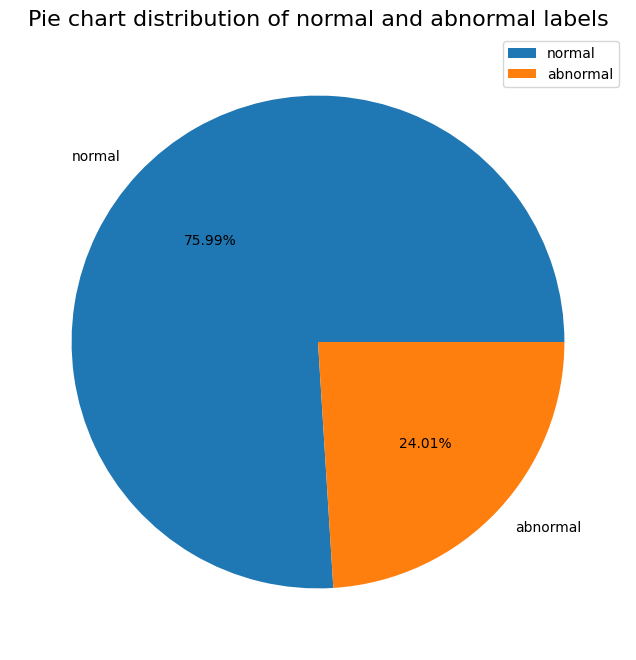

In [27]:
plt.figure(figsize=(8,8))
plt.pie(data.label.value_counts(),labels=['normal','abnormal'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
# plt.savefig('plots/Pie_chart_binary.png')
plt.show()

## **Multi-class Classification**

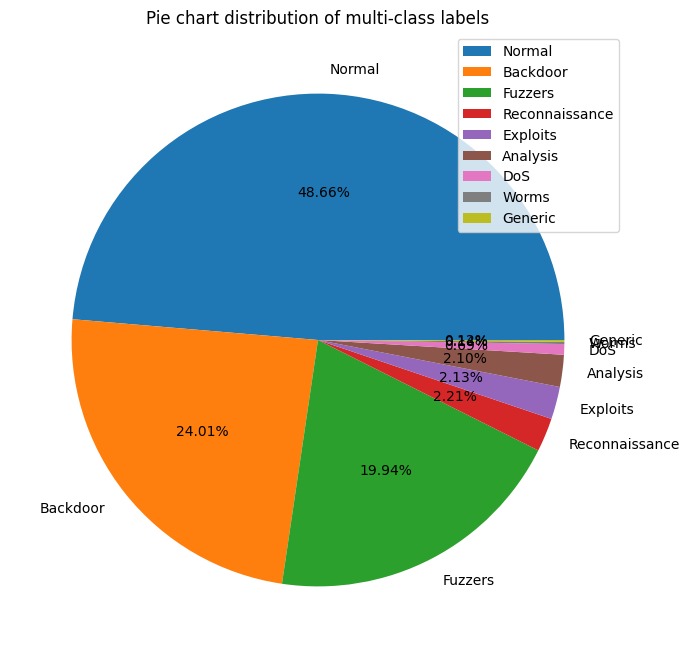

In [28]:
plt.figure(figsize=(8,8))
plt.pie(data.attack_cat.value_counts(),labels=data.attack_cat.unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend(loc='best')
# plt.savefig('plots/Pie_chart_multi.png')
plt.show()
#→ Lúc này model phải phân biệt nhiều loại tấn công khác nhau, 
# chứ không chỉ "tấn công" hay "không".

# **One hot encoding**

In [29]:
num_col = data.select_dtypes(include='number').columns

# selecting categorical data attributes
cat_col = data.columns.difference(num_col) # loại trừ kiểu số để ra phân loại
cat_col = cat_col[1:]
cat_col
#tách riêng cột dạng phân loại (categorical) 
# ra khỏi dữ liệu gốc để chuẩn bị mã hóa (encoding).

Index(['proto', 'service', 'state'], dtype='object')

In [30]:
# creating a dataframe with only categorical attributes
data_cat = data[cat_col].copy()
data_cat.head(n=10)
#thì data_cat chỉ là một view (ảnh chiếu) 
# của DataFrame data gốc — nghĩa là:nếu bro thay đổi dữ liệu 
# trong data_cat, có thể ảnh hưởng trực tiếp tới data gốc (hoặc ngược lại).

,proto,service,state
3,tcp,ftp,FIN
11,tcp,smtp,FIN
15,udp,snmp,INT
17,tcp,http,FIN
21,tcp,http,FIN
22,tcp,ftp,CON
28,tcp,http,FIN
30,tcp,http,FIN
31,tcp,http,FIN
32,tcp,http,FIN


In [31]:
# one-hot-encoding categorical attributes using pandas.get_dummies() function
##Hàm của pandas để tự động mã hóa one-hot
data_cat = pd.get_dummies(data_cat,columns=cat_col)
#Máy học (ML model) không hiểu chữ, nó chỉ hiểu số.
#→ One-hot encoding sẽ chuyển từng giá trị duy nhất (unique) thành một cột nhị phân (0 hoặc 1).
#| proto_tcp | proto_udp | state_FIN | state_EST | state_INT |
#| --------- | --------- | --------- | --------- | --------- |
#| 1         | 0         | 1         | 0         | 0         |
#| 0         | 1         | 0         | 1         | 0         |
#| 1         | 0         | 0         | 0         | 1         |
#kiểu protoco tách thành 2 cột riêng biệt

In [32]:
data_cat.head()

,proto_tcp,proto_udp,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
11,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
15,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
17,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
21,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False


In [33]:
data.shape



(81173, 45)

In [34]:
data = pd.concat([data, data_cat],axis=1)
#➡ Gộp các cột mới (đã mã hóa) từ data_cat vào data gốc


In [35]:
data.shape

(81173, 64)

In [36]:
data.drop(columns=cat_col,inplace=True)

In [37]:
data.shape

(81173, 61)

# **Data Normalization**


In [38]:
# selecting numeric attributes columns from data
num_col = list(data.select_dtypes(include='number').columns)
num_col.remove('id')
num_col.remove('label')
print(num_col)
#num_col là danh sách các cột số thực sự cần chuẩn hóa

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


In [39]:
# using minmax scaler for normalizing data
minmax_scale = MinMaxScaler(feature_range=(0, 1)) #range 0,1
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df
##phương pháp Min–Max Scaling,

In [40]:
# data before normalization
data.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST
3,4,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,...,False,False,False,False,False,False,True,False,False,False
11,12,2.093085,62,28,56329,2212,42.520967,62,252,2.118251e+05,...,False,True,False,False,False,False,True,False,False,False
15,16,0.000002,2,0,138,0,500000.001300,254,0,2.760000e+08,...,False,False,True,False,False,False,False,True,False,False
17,18,0.393556,10,8,860,1096,43.195886,62,252,1.573347e+04,...,False,False,False,False,False,False,True,False,False,False
21,22,0.338017,10,6,998,268,44.376468,254,252,2.127704e+04,...,False,False,False,False,False,False,True,False,False,False


In [41]:
# calling normalization() function
data = normalization(data.copy(),num_col)

In [42]:
# data after normalization
data.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST
3,4,2.802780e-02,0.001144,0.001093,0.000041,0.000053,0.000014,0.138393,0.992126,0.000001,...,False,False,False,False,False,False,True,False,False,False
11,12,3.488529e-02,0.006344,0.002551,0.004337,0.000151,0.000043,0.138393,0.992126,0.000092,...,False,True,False,False,False,False,True,False,False,False
15,16,1.666693e-08,0.000104,0.000000,0.000003,0.000000,0.500000,0.995536,0.000000,0.119792,...,False,False,True,False,False,False,False,True,False,False
17,18,6.559354e-03,0.000936,0.000729,0.000059,0.000075,0.000043,0.138393,0.992126,0.000007,...,False,False,False,False,False,False,True,False,False,False
21,22,5.633690e-03,0.000936,0.000547,0.000069,0.000018,0.000044,0.995536,0.992126,0.000009,...,False,False,False,False,False,False,True,False,False,False


# **Label Encoding**

## **Binary Labels**

In [43]:
# changing attack labels into two categories 'normal' and 'abnormal'
bin_label = pd.DataFrame(data.label.map(lambda x:'normal' if x==0 else 'abnormal'))
#phân loại label 0 thành 'normal', các giá trị khác thành 'abnormal'

In [44]:
# creating a dataframe with binary labels (normal,abnormal)
bin_data = data.copy() #copy lại để ko ảnh hg bản gốc
bin_data['label'] = bin_label

In [45]:
# label encoding (0,1) binary labels
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform) #học và gán mã số cho từng giá trị khác nhau.
bin_data['label'] = enc_label #áp dụng cho toàn bộ cột label.

In [46]:
le1.classes_

array(['abnormal', 'normal'], dtype=object)

In [47]:
np.save("le1_classes.npy",le1.classes_,allow_pickle=True)

## **Multi-class Labels**

In [48]:

# one-hot-encoding attack label
multi_data = data.copy()
multi_label = pd.DataFrame(multi_data.attack_cat)

In [49]:
multi_data = pd.get_dummies(multi_data,columns=['attack_cat'])

In [50]:
# label encoding (0,1,2,3,4,5,6,7,8) multi-class labels
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['label'] = enc_label

In [51]:
le2.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Worms'], dtype=object)

In [52]:
np.save("le2_classes.npy",le2.classes_,allow_pickle=True)

# **Correlation between features of dataset**

In [53]:
# num_col.append('label')
if num_col.count('label') > 0:
  num_col.remove('label')
if num_col.count('is_sm_ips_ports') > 0:
  num_col.remove('is_sm_ips_ports')
if num_col.count('id') > 0:
  num_col.remove('id')
  ##phân tích tương quan giwuxa các thuộc tính số
  ##loại bỏ những cột không cần tính tương quan 
  # (vì chúng không phải đặc trưng thực tế để phân tích).

## **Correlation Matrix for Binary Labels**

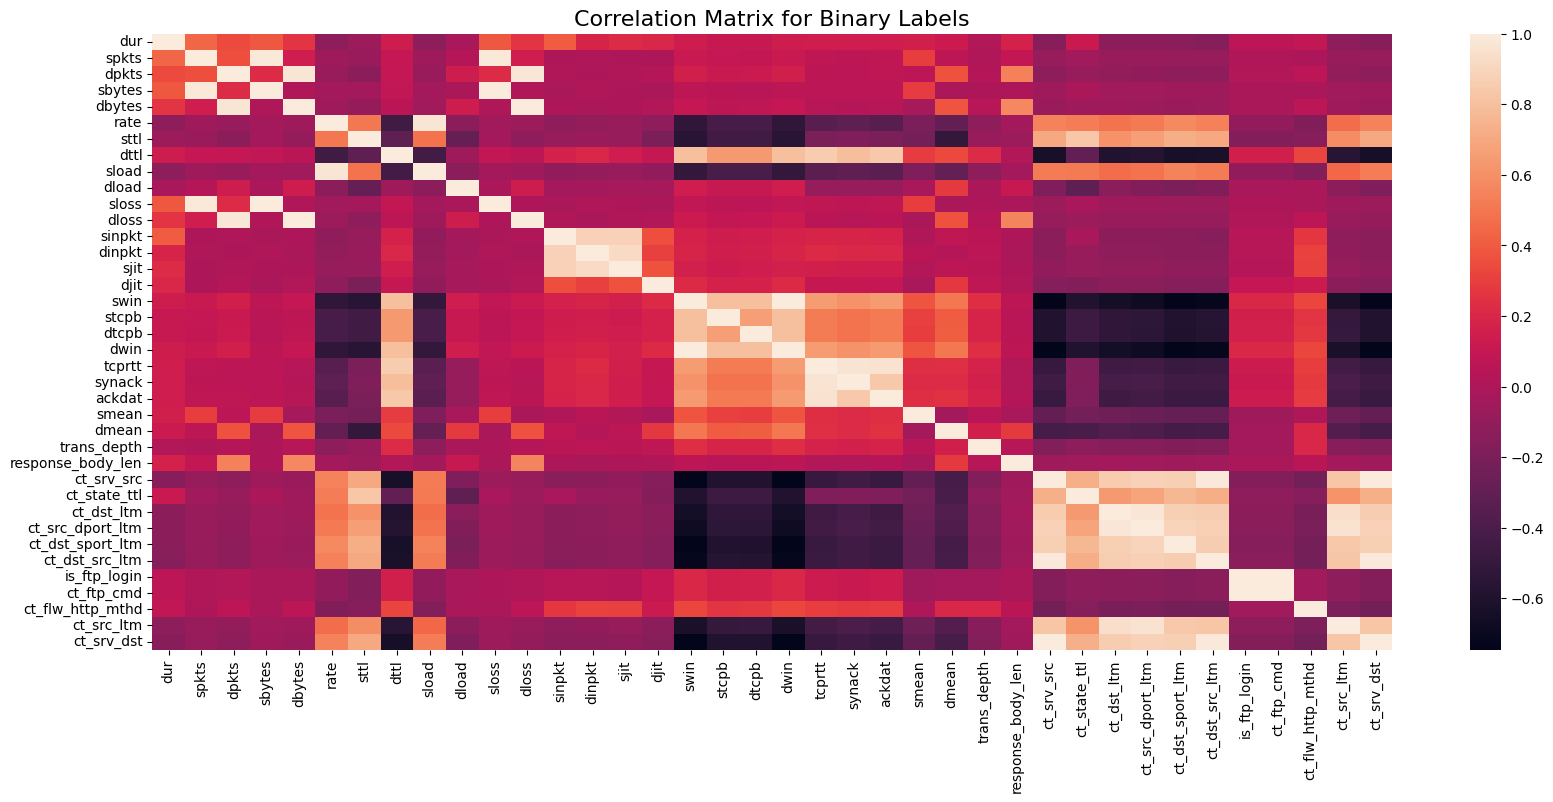

In [54]:
# Correlation Matrix for Binary Labels
plt.figure(figsize=(20,8))
corr_bin = bin_data[num_col].corr() #tính toán ma trận tương quan giữa các cột số trong bin_data
sns.heatmap(corr_bin,vmax=1.0,annot=False)
plt.title('Correlation Matrix for Binary Labels',fontsize=16)
# plt.savefig('plots/correlation_matrix_bin.png')
plt.show()
#màu nhạt  có mối tương quan mạnh,

## **Correlation Matrix for Multi-class Labels**

In [55]:
num_col = list(multi_data.select_dtypes(include='number').columns)
num_col.remove('label')
num_col.remove('is_sm_ips_ports')
num_col.remove('id')

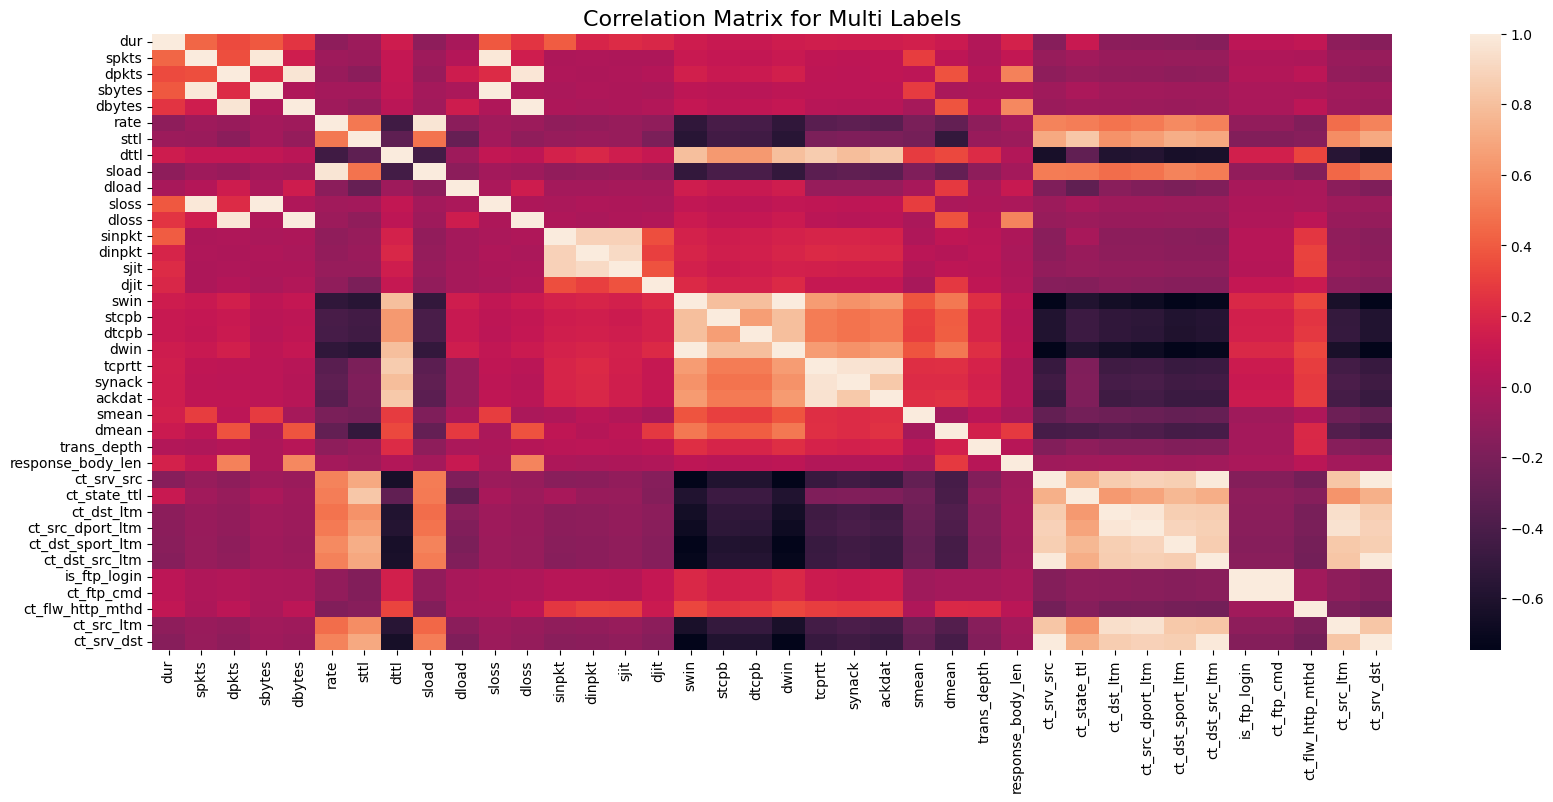

In [56]:
# Correlation Matrix for Multi-class Labels
plt.figure(figsize=(20,8))
corr_multi = multi_data[num_col].corr()
sns.heatmap(corr_multi,vmax=1.0,annot=False)
plt.title('Correlation Matrix for Multi Labels',fontsize=16)
# plt.savefig('plots/correlation_matrix_multi.png')
plt.show()
#Màu Nóng (Đỏ, Cam, Vàng, tiến về 1.0): Biểu thị tương quan dương mạnh
#Nghĩa là khi một biến tăng, biến kia cũng có xu hướng tăng theo 
# (và ngược lại, khi một biến giảm, biến kia cũng giảm).

# **Feature Selection**

## **Binary Labels**

In [57]:
# finding the attributes which have more than 0.3 correlation with encoded attack label attribute
#chọn đặc trưng dựa trên hệ số tương quan 
#tương quan cao với cột label (tức là biến mục tiêu cần dự đoán, ví dụ như tấn công / không tấn công, spam / không spam,...).
if num_col.count('label') < 1:
  num_col.append('label') #đảm bảo dsach num_col có cột 'label' vì cần label tính tương quan

corr_bin = bin_data[num_col].corr()
#→ Đây là ma trận hệ số Pearson (phạm vi từ -1 đến 1): 1 là tg quan hoàn hảo -1 ngược chiều 0 là 0
corr_ybin = abs(corr_bin['label'])
highest_corr_bin = corr_ybin[corr_ybin >0]
highest_corr_bin.sort_values(ascending=True)
#→ Tức là họ giữ những feature có tương quan Pearson ≥ 0.3 với label.
# Loại bỏ feature “ít liên quan” (ví dụ mấy cột IP, ID
#  không ảnh hưởng đến việc phân biệt attack/normal),

dinpkt               0.000054
spkts                0.010686
sloss                0.014274
sinpkt               0.015467
dur                  0.018005
sbytes               0.020540
trans_depth          0.021709
sjit                 0.029440
ct_flw_http_mthd     0.029566
dbytes               0.041428
response_body_len    0.045756
dloss                0.048563
is_ftp_login         0.050507
ct_ftp_cmd           0.050507
dpkts                0.063180
smean                0.102092
djit                 0.109551
dttl                 0.155827
synack               0.172863
dtcpb                0.181297
stcpb                0.184921
tcprtt               0.196270
ackdat               0.203839
swin                 0.227784
dwin                 0.227784
dmean                0.240989
sload                0.334562
dload                0.343910
rate                 0.344535
ct_src_ltm           0.368486
ct_dst_ltm           0.387358
ct_src_dport_ltm     0.444874
ct_srv_dst           0.459984
ct_srv_src

In [58]:
# highest_corr_bin = highest_corr_bin.drop(highest_corr_bin[highest_corr_bin.index == "sttl"].index)
# highest_corr_bin = highest_corr_bin.drop(highest_corr_bin[highest_corr_bin.index == "dttl"].index)
# highest_corr_bin = highest_corr_bin.drop(highest_corr_bin[highest_corr_bin.index == "ct_state_ttl"].index)
# highest_corr_bin = highest_corr_bin.drop(highest_corr_bin[highest_corr_bin.index == "tcprtt"].index)

In [59]:
# selecting attributes found by using pearson correlation coefficient
bin_cols = highest_corr_bin.index

In [60]:
bin_cols

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'label'],
      dtype='object')

In [61]:
# Binary labelled Dataset
bin_data = bin_data[bin_cols].copy()
bin_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label
3,2.802780e-02,0.001144,0.001093,0.000041,0.000053,0.000014,0.138393,0.992126,0.000001,0.000150,...,0.02,0.00,0.000000,0.039216,0.25,0.25,0.000000,0.016949,0.000000,1
11,3.488529e-02,0.006344,0.002551,0.004337,0.000151,0.000043,0.138393,0.992126,0.000092,0.000364,...,0.00,0.00,0.000000,0.019608,0.00,0.00,0.000000,0.000000,0.000000,1
15,1.666693e-08,0.000104,0.000000,0.000003,0.000000,0.500000,0.995536,0.000000,0.119792,0.000000,...,0.00,0.00,0.000000,0.058824,0.00,0.00,0.000000,0.016949,0.000000,1
17,6.559354e-03,0.000936,0.000729,0.000059,0.000075,0.000043,0.138393,0.992126,0.000007,0.000869,...,0.00,0.00,0.000000,0.019608,0.00,0.00,0.033333,0.000000,0.039216,1
21,5.633690e-03,0.000936,0.000547,0.000069,0.000018,0.000044,0.995536,0.992126,0.000009,0.000236,...,0.00,0.00,0.000000,0.000000,0.00,0.00,0.033333,0.016949,0.039216,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175335,8.333466e-08,0.000104,0.000000,0.000001,0.000000,0.166667,0.995536,0.000000,0.032986,0.000000,...,0.64,0.64,0.533333,0.862745,0.00,0.00,0.000000,0.542373,0.862745,0
175336,1.333355e-07,0.000104,0.000000,0.000001,0.000000,0.111111,0.995536,0.000000,0.021991,0.000000,...,0.46,0.46,0.400000,0.450980,0.00,0.00,0.000000,0.389831,0.450980,0
175338,1.333355e-07,0.000104,0.000000,0.000001,0.000000,0.111111,0.995536,0.000000,0.021991,0.000000,...,0.04,0.04,0.066667,0.235294,0.00,0.00,0.000000,0.033898,0.215686,0
175339,1.333355e-07,0.000104,0.000000,0.000001,0.000000,0.111111,0.995536,0.000000,0.021991,0.000000,...,0.58,0.58,0.433333,0.568627,0.00,0.00,0.000000,0.491525,0.568627,0


### **Saving Prepared Dataset to Disk**

In [62]:
# bin_data.to_csv('/Papi/bin_data.csv')

## **Multi-class Labels**

In [63]:
# finding the attributes which have more than 0.3 correlation with encoded attack label attribute
if num_col.count('label') < 1:
  num_col.append('label')

# corr_bin = bin_data[num_col].corr()
corr_multi = multi_data[num_col].corr()

corr_ymulti = abs(corr_multi['label'])
highest_corr_multi = corr_ymulti[corr_ymulti > 0]
highest_corr_multi.sort_values(ascending=True)

sttl                 0.000470
response_body_len    0.002389
dbytes               0.023108
dloss                0.032671
djit                 0.037583
dpkts                0.044338
sbytes               0.075197
spkts                0.075258
sloss                0.079995
is_ftp_login         0.090233
ct_ftp_cmd           0.090233
sjit                 0.100354
trans_depth          0.102748
sload                0.108604
rate                 0.119870
sinpkt               0.131731
dinpkt               0.138084
dur                  0.145299
dmean                0.149699
ct_src_dport_ltm     0.156531
smean                0.158964
ct_dst_sport_ltm     0.167716
ct_state_ttl         0.172041
dload                0.175118
ct_dst_src_ltm       0.181526
ct_src_ltm           0.182708
ct_srv_src           0.185625
ct_dst_ltm           0.187515
ct_srv_dst           0.190095
ct_flw_http_mthd     0.233513
stcpb                0.286271
dtcpb                0.291727
swin                 0.364393
dwin      

In [64]:
# highest_corr_multi = highest_corr_multi.drop(highest_corr_multi[highest_corr_multi.index == "sttl"].index)
# highest_corr_multi = highest_corr_multi.drop(highest_corr_multi[highest_corr_multi.index == "dttl"].index)
# highest_corr_multi = highest_corr_multi.drop(highest_corr_multi[highest_corr_multi.index == "ct_state_ttl"].index)
# highest_corr_multi = highest_corr_multi.drop(highest_corr_multi[highest_corr_multi.index == "tcprtt"].index)

In [65]:
# selecting attributes found by using pearson correlation coefficient
multi_cols = highest_corr_multi.index
multi_cols

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'label'],
      dtype='object')

In [66]:
# Multi-class labelled Dataset
multi_data = multi_data[multi_cols].copy()

### **Saving Prepared Dataset to Disk**

In [67]:
# multi_data.to_csv('./datasets/multi_data.csv')

# **BINARY CLASSIFICATION**

## **Data Splitting**



In [68]:
# features_to_exclude = ['sload', 'dload', 'ct_dst_ltm']

In [69]:
X = bin_data.drop(columns=['label'],axis=1)
Y = bin_data['label']

In [70]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

## **Linear Regression**

In [71]:

lr_bin = LinearRegression()

from datetime import datetime
start = datetime.now()
lr_bin.fit(X_train, y_train)
end = datetime.now()
lr_trainTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 167556.0 µs


In [72]:
from datetime import datetime
start = datetime.now()
y_pred = lr_bin.predict(X_test)
end = datetime.now()
lr_inferTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 13130.0 µs


In [73]:
round = lambda x:1 if x>0.6 else 0
vfunc = np.vectorize(round)
y_pred = vfunc(y_pred)

In [74]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred)*100)

Mean Absolute Error -  0.022728672620880814
Mean Squared Error -  0.022728672620880814
Root Mean Squared Error -  0.15076031513923288
R2 Score -  87.75461147232926
Accuracy -  97.72713273791192


In [75]:
original_accuracy = accuracy_score(y_test, y_pred)
accuracy_drop = {}

for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = lr_bin.predict(X_test_modified)
    y_pred_modified_adjusted = np.maximum(0, y_pred_modified)
    y_pred_binary_modified = (y_pred_modified_adjusted > 0.6).astype(int)
    new_accuracy = accuracy_score(y_test, y_pred_binary_modified)
    drop = original_accuracy - new_accuracy
    # if drop > 0:
    #     accuracy_drop[feature] = drop
    accuracy_drop[feature] = drop
for feature, drop in sorted(accuracy_drop.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: Accuracy Drop = {drop}")

ct_state_ttl: Accuracy Drop = 0.48838928241453644
dttl: Accuracy Drop = 0.15485063135201715
dpkts: Accuracy Drop = 0.0059747459193101315
dbytes: Accuracy Drop = 0.0053587927317523265
sloss: Accuracy Drop = 0.004373267631659905
dloss: Accuracy Drop = 0.0034493378503233085
sjit: Accuracy Drop = 0.0004927625500461552
sinpkt: Accuracy Drop = 0.0003079765937787915
dinpkt: Accuracy Drop = 0.0001847859562672527
sttl: Accuracy Drop = 6.159531875571389e-05
dmean: Accuracy Drop = 6.159531875571389e-05
spkts: Accuracy Drop = 0.0
sbytes: Accuracy Drop = 0.0
rate: Accuracy Drop = 0.0
sload: Accuracy Drop = 0.0
dload: Accuracy Drop = 0.0
swin: Accuracy Drop = 0.0
stcpb: Accuracy Drop = 0.0
dtcpb: Accuracy Drop = 0.0
dwin: Accuracy Drop = 0.0
tcprtt: Accuracy Drop = 0.0
synack: Accuracy Drop = 0.0
ackdat: Accuracy Drop = 0.0
smean: Accuracy Drop = 0.0
trans_depth: Accuracy Drop = 0.0
response_body_len: Accuracy Drop = 0.0
ct_srv_src: Accuracy Drop = 0.0
ct_dst_ltm: Accuracy Drop = 0.0
ct_src_dport_lt

In [76]:
accuracy_drop_lr_sorted = sorted(accuracy_drop.items(), key=lambda x: x[0], reverse=False)
# accuracy_drop_lr_sorted

In [77]:
X_test_modified_ct_state_ttl = X_test.copy()
X_test_modified_ct_state_ttl['ct_state_ttl'] = 0
y_pred_modified_ct_state_ttl = lr_bin.predict(X_test_modified_ct_state_ttl)
y_pred_binary_modified_ct_state_ttl = (np.maximum(0, y_pred_modified_ct_state_ttl) > 0.6).astype(int)
new_accuracy_ct_state_ttl = accuracy_score(y_test, y_pred_binary_modified_ct_state_ttl)
drop_ct_state_ttl = original_accuracy - new_accuracy_ct_state_ttl

In [78]:
X_test_modified_ct_dst_src_ltm = X_test.copy()
X_test_modified_ct_dst_src_ltm['ct_dst_src_ltm'] = 0
y_pred_modified_ct_dst_src_ltm = lr_bin.predict(X_test_modified_ct_dst_src_ltm)
y_pred_binary_modified_ct_dst_src_ltm = (np.maximum(0, y_pred_modified_ct_dst_src_ltm) > 0.6).astype(int)
new_accuracy_ct_dst_src_ltm = accuracy_score(y_test, y_pred_binary_modified_ct_dst_src_ltm)
drop_ct_dst_src_ltm = original_accuracy - new_accuracy_ct_dst_src_ltm

In [79]:
print(f"Original Accuracy: {original_accuracy}")
print(f"Accuracy after masking 'ct_state_ttl': {new_accuracy_ct_state_ttl} (Drop: {drop_ct_state_ttl})")
print(f"Accuracy after masking 'ct_dst_src_ltm': {new_accuracy_ct_dst_src_ltm} (Drop: {drop_ct_dst_src_ltm})")


Original Accuracy: 0.9772713273791191
Accuracy after masking 'ct_state_ttl': 0.4888820449645827 (Drop: 0.48838928241453644)
Accuracy after masking 'ct_dst_src_ltm': 0.9772713273791191 (Drop: 0.0)


In [80]:
X_test_modified_both = X_test.copy()

In [81]:
X_test_modified_both['ct_state_ttl'] = 0
X_test_modified_both['ct_dst_src_ltm'] = 0
y_pred_modified_both = lr_bin.predict(X_test_modified_both)
y_pred_binary_modified_both = (np.maximum(0, y_pred_modified_both) > 0.6).astype(int)
new_accuracy_both = accuracy_score(y_test, y_pred_binary_modified_both)

# Calculate the accuracy drop when both features are masked
drop_both = original_accuracy - new_accuracy_both
print(f"Original Accuracy: {original_accuracy}")
print(f"Accuracy after masking 'ct_state_ttl' and 'ct_dst_src_ltm' together: {new_accuracy_both} (Drop: {drop_both})")


Original Accuracy: 0.9772713273791191
Accuracy after masking 'ct_state_ttl' and 'ct_dst_src_ltm' together: 0.4885740683708038 (Drop: 0.48869725900831534)


In [82]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)

In [83]:
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       0.99      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



### **Saving Trained Model to Disk**

In [84]:
# pkl_filename = "./models/linear_regressor_binary.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(lr_bin, file)
#   print("Saved model to disk")
# else:
#   print("Previous Model exists on the disk! Please Remove")

## **Logistic Regression**

In [85]:
logr_bin = LogisticRegression(random_state=123, max_iter=5000)
logr_bin

LogisticRegression(max_iter=5000, random_state=123)

In [86]:

from datetime import datetime
start = datetime.now()
logr_bin.fit(X_train,y_train)
end = datetime.now()
lgr_trainTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 362960.0 µs


In [87]:

from datetime import datetime
start = datetime.now()
y_pred1 = logr_bin.predict(X_test)
end = datetime.now()
lgr_inferTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 4360.0 µs


In [88]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred1)*100)

Mean Absolute Error -  0.022728672620880814
Mean Squared Error -  0.022728672620880814
Root Mean Squared Error -  0.15076031513923288
R2 Score -  87.75461147232926
Accuracy -  97.8688019710502


In [89]:
original_accuracy_logr = accuracy_score(y_test, y_pred1)
print(f"Original Accuracy: {original_accuracy_logr*100:.5f}%")
accuracy_drop_logr = {}
for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = logr_bin.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop_logr[feature] = original_accuracy_logr - new_accuracy
print("\nOcclusion Sensitivity Analysis (Logistic Regression):")
# positive_including_zero_accuracy_drop_logr = {feature: drop for feature, drop in accuracy_drop_logr.items() if drop >= 0}
positive_including_zero_accuracy_drop_logr = {feature: drop for feature, drop in accuracy_drop_logr.items()}

for feature, drop in sorted(positive_including_zero_accuracy_drop_logr.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: Accuracy Drop = {drop:.4f}")

Original Accuracy: 97.86880%

Occlusion Sensitivity Analysis (Logistic Regression):
ct_state_ttl: Accuracy Drop = 0.3022
dttl: Accuracy Drop = 0.2483
ct_dst_sport_ltm: Accuracy Drop = 0.0007
sttl: Accuracy Drop = 0.0006
dmean: Accuracy Drop = 0.0001
ct_dst_ltm: Accuracy Drop = 0.0001
ct_src_dport_ltm: Accuracy Drop = 0.0001
swin: Accuracy Drop = 0.0001
dwin: Accuracy Drop = 0.0001
smean: Accuracy Drop = 0.0001
ct_src_ltm: Accuracy Drop = 0.0001
spkts: Accuracy Drop = 0.0000
dpkts: Accuracy Drop = 0.0000
sbytes: Accuracy Drop = 0.0000
dbytes: Accuracy Drop = 0.0000
sload: Accuracy Drop = 0.0000
dload: Accuracy Drop = 0.0000
sloss: Accuracy Drop = 0.0000
dloss: Accuracy Drop = 0.0000
sinpkt: Accuracy Drop = 0.0000
dinpkt: Accuracy Drop = 0.0000
sjit: Accuracy Drop = 0.0000
djit: Accuracy Drop = 0.0000
stcpb: Accuracy Drop = 0.0000
dtcpb: Accuracy Drop = 0.0000
synack: Accuracy Drop = 0.0000
ackdat: Accuracy Drop = 0.0000
trans_depth: Accuracy Drop = 0.0000
response_body_len: Accuracy Dro

In [90]:
positive_including_zero_accuracy_drop_logr_sorted = sorted(positive_including_zero_accuracy_drop_logr.items(), key=lambda x: x[0], reverse=False)

In [91]:
len(positive_including_zero_accuracy_drop_logr_sorted)

38

In [92]:
X_test_modified_both = X_test.copy()
X_test_modified_both['ct_state_ttl'] = 0
X_test_modified_both['ct_dst_src_ltm'] = 0
y_pred_modified_both = logr_bin.predict(X_test_modified_both)
new_accuracy_both = accuracy_score(y_test, y_pred_modified_both)
drop_both = original_accuracy_logr - new_accuracy_both
print(f"Original Accuracy: {original_accuracy_logr*100:.5f}%")
print(f"Accuracy after masking 'ct_state_ttl' and 'ct_dst_src_ltm' together: {new_accuracy_both*100:.5f}% (Drop: {drop_both*100:.5f}%)")

Original Accuracy: 97.86880%
Accuracy after masking 'ct_state_ttl' and 'ct_dst_src_ltm' together: 67.83492% (Drop: 30.03388%)


In [93]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       0.99      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



### **Saving Trained Model to Disk**

In [94]:
# pkl_filename = "./models/logistic_regressor_binary.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(logr_bin, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **Linear Support Vector Machine**

In [95]:
lsvm_bin = SVC(kernel='linear',gamma='auto')

from datetime import datetime
start = datetime.now()
lsvm_bin.fit(X_train,y_train)
end = datetime.now()
lsvm_trainTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 46905227.0 µs


In [96]:
from datetime import datetime
start = datetime.now()
y_pred2 = lsvm_bin.predict(X_test)
end = datetime.now()
lsvm_inferTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 2162068.0 µs


In [97]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred2)*100)

Mean Absolute Error -  0.022728672620880814
Mean Squared Error -  0.022728672620880814
Root Mean Squared Error -  0.15076031513923288
R2 Score -  87.75461147232926
Accuracy -  97.8688019710502


In [98]:
original_accuracy_lsvm = accuracy_score(y_test, y_pred2)
print(f"Original Accuracy: {original_accuracy_lsvm*100:.5f}%")
accuracy_drop_lsvm = {}
for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = lsvm_bin.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop_lsvm[feature] = original_accuracy_lsvm - new_accuracy
print("\nOcclusion Sensitivity Analysis (Linear SVM):")
for feature, drop in sorted(accuracy_drop_lsvm.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: Accuracy Drop = {drop:.4f}")

Original Accuracy: 97.86880%

Occlusion Sensitivity Analysis (Linear SVM):
ct_state_ttl: Accuracy Drop = 0.7337
dttl: Accuracy Drop = 0.2475
dur: Accuracy Drop = 0.0000
spkts: Accuracy Drop = 0.0000
dpkts: Accuracy Drop = 0.0000
sbytes: Accuracy Drop = 0.0000
dbytes: Accuracy Drop = 0.0000
rate: Accuracy Drop = 0.0000
sttl: Accuracy Drop = 0.0000
sload: Accuracy Drop = 0.0000
dload: Accuracy Drop = 0.0000
sloss: Accuracy Drop = 0.0000
dloss: Accuracy Drop = 0.0000
sinpkt: Accuracy Drop = 0.0000
dinpkt: Accuracy Drop = 0.0000
sjit: Accuracy Drop = 0.0000
djit: Accuracy Drop = 0.0000
swin: Accuracy Drop = 0.0000
stcpb: Accuracy Drop = 0.0000
dtcpb: Accuracy Drop = 0.0000
dwin: Accuracy Drop = 0.0000
tcprtt: Accuracy Drop = 0.0000
synack: Accuracy Drop = 0.0000
ackdat: Accuracy Drop = 0.0000
smean: Accuracy Drop = 0.0000
dmean: Accuracy Drop = 0.0000
trans_depth: Accuracy Drop = 0.0000
response_body_len: Accuracy Drop = 0.0000
ct_srv_src: Accuracy Drop = 0.0000
ct_dst_ltm: Accuracy Drop =

In [99]:
accuracy_drop_lsvm_sorted = sorted(accuracy_drop_lsvm.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_lsvm_sorted

[('ackdat', 0.0),
 ('ct_dst_ltm', 0.0),
 ('ct_dst_sport_ltm', 0.0),
 ('ct_dst_src_ltm', 0.0),
 ('ct_flw_http_mthd', 0.0),
 ('ct_ftp_cmd', 0.0),
 ('ct_src_dport_ltm', 0.0),
 ('ct_src_ltm', 0.0),
 ('ct_srv_dst', 0.0),
 ('ct_srv_src', 0.0),
 ('ct_state_ttl', 0.7336618417000308),
 ('dbytes', 0.0),
 ('dinpkt', 0.0),
 ('djit', 0.0),
 ('dload', 0.0),
 ('dloss', 0.0),
 ('dmean', 0.0),
 ('dpkts', 0.0),
 ('dtcpb', 0.0),
 ('dttl', 0.24748999076070222),
 ('dur', 0.0),
 ('dwin', 0.0),
 ('is_ftp_login', 0.0),
 ('rate', 0.0),
 ('response_body_len', 0.0),
 ('sbytes', 0.0),
 ('sinpkt', 0.0),
 ('sjit', 0.0),
 ('sload', 0.0),
 ('sloss', 0.0),
 ('smean', 0.0),
 ('spkts', 0.0),
 ('stcpb', 0.0),
 ('sttl', 0.0),
 ('swin', 0.0),
 ('synack', 0.0),
 ('tcprtt', 0.0),
 ('trans_depth', 0.0)]

In [100]:
X_test_modified = X_test.copy()
X_test_modified['ct_state_ttl'] = 0
y_pred_modified = lsvm_bin.predict(X_test_modified)
new_accuracy = accuracy_score(y_test, y_pred_modified)
drop = original_accuracy_lsvm - new_accuracy
print(f"Original Accuracy: {original_accuracy_lsvm*100:.5f}%")
print(f"Accuracy after masking 'ct_state_ttl': {new_accuracy*100:.5f}% (Drop: {drop*100:.5f}%)")

Original Accuracy: 97.86880%
Accuracy after masking 'ct_state_ttl': 24.50262% (Drop: 73.36618%)


In [101]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       0.99      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



### **Saving Trained Model to Disk**

In [102]:
# pkl_filename = "./models/lsvm_binary.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(lsvm_bin, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **K Nearest Neighbor Classifier**

In [103]:
knn_bin=KNeighborsClassifier(n_neighbors=5)

from datetime import datetime
start = datetime.now()
knn_bin.fit(X_train,y_train)
end = datetime.now()
knn_trainTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 52256.0 µs


In [104]:
from datetime import datetime
start = datetime.now()
y_pred3 = knn_bin.predict(X_test)
end = datetime.now()
knn_inferTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 8726956.0 µs


In [105]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred3)*100)

Mean Absolute Error -  0.022728672620880814
Mean Squared Error -  0.022728672620880814
Root Mean Squared Error -  0.15076031513923288
R2 Score -  87.75461147232926
Accuracy -  98.0843855866954


In [106]:
original_accuracy_knn = accuracy_score(y_test, y_pred3)
print(f"Original Accuracy: {original_accuracy_knn*100:.5f}%")
accuracy_drop_knn = {}
for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = knn_bin.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop_knn[feature] = original_accuracy_knn - new_accuracy
print("\nOcclusion Sensitivity Analysis (KNN Classifier):")
for feature, drop in sorted(accuracy_drop_knn.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: Accuracy Drop = {drop:.4f}")

Original Accuracy: 98.08439%

Occlusion Sensitivity Analysis (KNN Classifier):
dttl: Accuracy Drop = 0.2150
sttl: Accuracy Drop = 0.0233
dmean: Accuracy Drop = 0.0024
dtcpb: Accuracy Drop = 0.0022
ct_flw_http_mthd: Accuracy Drop = 0.0014
stcpb: Accuracy Drop = 0.0012
smean: Accuracy Drop = 0.0011
ct_srv_dst: Accuracy Drop = 0.0010
ct_state_ttl: Accuracy Drop = 0.0009
ct_dst_src_ltm: Accuracy Drop = 0.0006
ct_srv_src: Accuracy Drop = 0.0005
sjit: Accuracy Drop = 0.0002
synack: Accuracy Drop = 0.0002
dur: Accuracy Drop = 0.0002
sinpkt: Accuracy Drop = 0.0002
dinpkt: Accuracy Drop = 0.0002
ct_dst_ltm: Accuracy Drop = 0.0001
is_ftp_login: Accuracy Drop = 0.0001
ct_ftp_cmd: Accuracy Drop = 0.0001
ct_dst_sport_ltm: Accuracy Drop = 0.0001
spkts: Accuracy Drop = 0.0000
dpkts: Accuracy Drop = 0.0000
sbytes: Accuracy Drop = 0.0000
dbytes: Accuracy Drop = 0.0000
sload: Accuracy Drop = 0.0000
dload: Accuracy Drop = 0.0000
sloss: Accuracy Drop = 0.0000
dloss: Accuracy Drop = 0.0000
djit: Accuracy D

In [107]:
accuracy_drop_knn_sorted = sorted(accuracy_drop_knn.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_knn_sorted

[('ackdat', -0.0002463812750230776),
 ('ct_dst_ltm', 0.0001231906375115388),
 ('ct_dst_sport_ltm', 6.159531875571389e-05),
 ('ct_dst_src_ltm', 0.0005543578688019801),
 ('ct_flw_http_mthd', 0.0013550970126270379),
 ('ct_ftp_cmd', 0.0001231906375115388),
 ('ct_src_dport_ltm', -6.159531875582491e-05),
 ('ct_src_ltm', -0.0002463812750230776),
 ('ct_srv_dst', 0.0009855251000924214),
 ('ct_srv_src', 0.0004927625500461552),
 ('ct_state_ttl', 0.0009239297813365965),
 ('dbytes', 0.0),
 ('dinpkt', 0.00018478595626736372),
 ('djit', 0.0),
 ('dload', 0.0),
 ('dloss', 0.0),
 ('dmean', 0.002402217431475173),
 ('dpkts', 0.0),
 ('dtcpb', 0.0021558361564520956),
 ('dttl', 0.21502925777640902),
 ('dur', 0.00018478595626736372),
 ('dwin', 0.0),
 ('is_ftp_login', 0.0001231906375115388),
 ('rate', -6.159531875582491e-05),
 ('response_body_len', 0.0),
 ('sbytes', 0.0),
 ('sinpkt', 0.00018478595626736372),
 ('sjit', 0.0002463812750230776),
 ('sload', 0.0),
 ('sloss', 0.0),
 ('smean', 0.0011087157376039602),


In [108]:
X_test_modified_both = X_test.copy()
X_test_modified_both['ct_state_ttl'] = 0
X_test_modified_both['sttl'] = 0
y_pred_modified_both = knn_bin.predict(X_test_modified_both)
new_accuracy_both = accuracy_score(y_test, y_pred_modified_both)
drop_both = original_accuracy_knn - new_accuracy_both
print(f"Original Accuracy: {original_accuracy_knn*100:.5f}%")
print(f"Accuracy after masking 'ct_state_ttl' and 'sttl' together: {new_accuracy_both*100:.5f}% (Drop: {drop_both*100:.5f}%)")


Original Accuracy: 98.08439%
Accuracy after masking 'ct_state_ttl' and 'sttl' together: 76.75393% (Drop: 21.33046%)


In [109]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       0.99      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



### **Saving Trained Model to Disk**

In [110]:
# pkl_filename = "./models/knn_binary.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(knn_bin, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **Random Forest Classifier**

In [111]:
rf_bin = RandomForestClassifier(random_state=123)

from datetime import datetime
start = datetime.now()
rf_bin.fit(X_train,y_train)
end = datetime.now()
rf_trainTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 24946265.0 µs


In [112]:
from datetime import datetime
start = datetime.now()
y_pred4 = rf_bin.predict(X_test)
end = datetime.now()
rf_inferTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 352257.0 µs


In [113]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred4)*100)

Mean Absolute Error -  0.022728672620880814
Mean Squared Error -  0.022728672620880814
Root Mean Squared Error -  0.15076031513923288
R2 Score -  87.75461147232926
Accuracy -  98.80505081613798


In [114]:
original_accuracy_rf = accuracy_score(y_test, y_pred4)
print(f"Original Accuracy: {original_accuracy_rf*100:.5f}%")
accuracy_drop_rf = {}
for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = rf_bin.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop_rf[feature] = original_accuracy_rf - new_accuracy
print("\nOcclusion Sensitivity Analysis (Random Forest Classifier):")
for feature, drop in sorted(accuracy_drop_rf.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: Accuracy Drop = {drop:.4f}")

Original Accuracy: 98.80505%

Occlusion Sensitivity Analysis (Random Forest Classifier):
dbytes: Accuracy Drop = 0.0058
ct_srv_dst: Accuracy Drop = 0.0056
ct_srv_src: Accuracy Drop = 0.0043
ct_dst_src_ltm: Accuracy Drop = 0.0037
dmean: Accuracy Drop = 0.0023
sttl: Accuracy Drop = 0.0018
smean: Accuracy Drop = 0.0017
sbytes: Accuracy Drop = 0.0011
dload: Accuracy Drop = 0.0010
synack: Accuracy Drop = 0.0009
sjit: Accuracy Drop = 0.0007
dur: Accuracy Drop = 0.0006
ct_flw_http_mthd: Accuracy Drop = 0.0006
dinpkt: Accuracy Drop = 0.0006
response_body_len: Accuracy Drop = 0.0006
dttl: Accuracy Drop = 0.0004
dwin: Accuracy Drop = 0.0002
trans_depth: Accuracy Drop = 0.0002
tcprtt: Accuracy Drop = 0.0002
ct_src_dport_ltm: Accuracy Drop = 0.0001
ct_dst_sport_ltm: Accuracy Drop = 0.0001
ct_ftp_cmd: Accuracy Drop = 0.0001
djit: Accuracy Drop = 0.0001
swin: Accuracy Drop = 0.0000
dtcpb: Accuracy Drop = 0.0000
ct_dst_ltm: Accuracy Drop = -0.0001
is_ftp_login: Accuracy Drop = -0.0001
ct_src_ltm: Acc

In [115]:
accuracy_drop_rf_sorted = sorted(accuracy_drop_rf.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_rf_sorted

[('ackdat', -0.0007391438250693438),
 ('ct_dst_ltm', -6.159531875582491e-05),
 ('ct_dst_sport_ltm', 0.0001231906375115388),
 ('ct_dst_src_ltm', 0.003695719125346497),
 ('ct_flw_http_mthd', 0.000615953187557694),
 ('ct_ftp_cmd', 0.0001231906375115388),
 ('ct_src_dport_ltm', 0.0001231906375115388),
 ('ct_src_ltm', -6.159531875582491e-05),
 ('ct_srv_dst', 0.005605174006775515),
 ('ct_srv_src', 0.004250076994148477),
 ('ct_state_ttl', -0.0003695719125346164),
 ('dbytes', 0.005789959963042768),
 ('dinpkt', 0.0005543578688019801),
 ('djit', 6.159531875582491e-05),
 ('dload', 0.0009855251000924214),
 ('dloss', -0.0002463812750230776),
 ('dmean', 0.0022790267939636344),
 ('dpkts', -0.0007391438250693438),
 ('dtcpb', 0.0),
 ('dttl', 0.0004311672312904413),
 ('dur', 0.000615953187557694),
 ('dwin', 0.0002463812750230776),
 ('is_ftp_login', -6.159531875582491e-05),
 ('rate', -0.00018478595626736372),
 ('response_body_len', 0.0005543578688019801),
 ('sbytes', 0.0011087157376039602),
 ('sinpkt', -0

In [116]:
original_accuracy_rf

0.9880505081613797

In [117]:
X_test_modified_both = X_test.copy()
X_test_modified_both['sttl'] = 0
X_test_modified_both['ct_srv_src'] = 0
y_pred_modified_both = rf_bin.predict(X_test_modified_both)
new_accuracy_both = accuracy_score(y_test, y_pred_modified_both)
drop_both = original_accuracy_rf - new_accuracy_both
print(f"Original Accuracy: {original_accuracy_rf*100:.5f}%")
print(f"Accuracy after masking 'sttl' and 'ct_srv_src' together: {new_accuracy_both*100:.5f}% (Drop: {drop_both*100:.5f}%)")

Original Accuracy: 98.80505%
Accuracy after masking 'sttl' and 'ct_srv_src' together: 98.52171% (Drop: 0.28334%)


In [118]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       0.99      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



### **Saving Trained Model to Disk**

In [119]:
# pkl_filename = "./models/random_forest_binary.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(rf_bin, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **Decision Tree Classifier**

In [120]:
dt_bin = DecisionTreeClassifier(random_state=123)

from datetime import datetime
start = datetime.now()
dt_bin.fit(X_train,y_train)
end = datetime.now()
dt_trainTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 2814613.0 µs


In [121]:
y_pred5 = dt_bin.predict(X_test)

from datetime import datetime
start = datetime.now()
y_pred5 = dt_bin.predict(X_test)
end = datetime.now()
dt_inferTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 43536.0 µs


In [122]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred5)*100)

Mean Absolute Error -  0.022728672620880814
Mean Squared Error -  0.022728672620880814
Root Mean Squared Error -  0.15076031513923288
R2 Score -  87.75461147232926
Accuracy -  98.31844779796735


In [123]:
original_accuracy_dt = accuracy_score(y_test, y_pred5)
print(f"Original Accuracy: {original_accuracy_dt*100:.5f}%")
accuracy_drop_dt = {}
for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = dt_bin.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop_dt[feature] = original_accuracy_dt - new_accuracy
print("\nOcclusion Sensitivity Analysis (Decision Tree Classifier):")
for feature, drop in sorted(accuracy_drop_dt.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: Accuracy Drop = {drop:.4f}")

Original Accuracy: 98.31845%



Occlusion Sensitivity Analysis (Decision Tree Classifier):
sttl: Accuracy Drop = 0.7424
sload: Accuracy Drop = 0.1242
ct_srv_src: Accuracy Drop = 0.0389
dload: Accuracy Drop = 0.0279
sbytes: Accuracy Drop = 0.0151
dmean: Accuracy Drop = 0.0131
dtcpb: Accuracy Drop = 0.0118
synack: Accuracy Drop = 0.0075
dbytes: Accuracy Drop = 0.0072
rate: Accuracy Drop = 0.0063
ct_srv_dst: Accuracy Drop = 0.0053
ct_dst_src_ltm: Accuracy Drop = 0.0049
dinpkt: Accuracy Drop = 0.0043
trans_depth: Accuracy Drop = 0.0036
smean: Accuracy Drop = 0.0034
djit: Accuracy Drop = 0.0026
stcpb: Accuracy Drop = 0.0026
ackdat: Accuracy Drop = 0.0026
ct_flw_http_mthd: Accuracy Drop = 0.0025
sinpkt: Accuracy Drop = 0.0023
response_body_len: Accuracy Drop = 0.0022
sjit: Accuracy Drop = 0.0018
dur: Accuracy Drop = 0.0018
ct_src_ltm: Accuracy Drop = 0.0015
ct_dst_ltm: Accuracy Drop = 0.0014
tcprtt: Accuracy Drop = 0.0006
spkts: Accuracy Drop = 0.0005
sloss: Accuracy Drop = 0.0001
ct_src_dport_ltm: Accuracy Drop = 0.0001


In [124]:
accuracy_drop_dt_sorted = sorted(accuracy_drop_dt.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_dt_sorted

[('ackdat', 0.002587003387742537),
 ('ct_dst_ltm', 0.0014166923313828628),
 ('ct_dst_sport_ltm', 0.0),
 ('ct_dst_src_ltm', 0.004927625500461996),
 ('ct_flw_http_mthd', 0.002525408068986823),
 ('ct_ftp_cmd', -6.159531875571389e-05),
 ('ct_src_dport_ltm', 0.0001231906375115388),
 ('ct_src_ltm', 0.0014782876501385767),
 ('ct_srv_dst', 0.005297197412996613),
 ('ct_srv_src', 0.03886664613489377),
 ('ct_state_ttl', 0.0),
 ('dbytes', 0.007206652294425631),
 ('dinpkt', 0.004311672312904191),
 ('djit', 0.002587003387742537),
 ('dload', 0.027902679396365926),
 ('dloss', 0.0),
 ('dmean', 0.013119802894980048),
 ('dpkts', -6.159531875571389e-05),
 ('dtcpb', 0.01176470588235301),
 ('dttl', 0.0),
 ('dur', 0.0017862642439174792),
 ('dwin', 0.0),
 ('is_ftp_login', 0.0),
 ('rate', 0.006344317831844748),
 ('response_body_len', 0.0021558361564520956),
 ('sbytes', 0.01509085309516478),
 ('sinpkt', 0.0022790267939636344),
 ('sjit', 0.001847859562673304),
 ('sload', 0.12423775793039726),
 ('sloss', 0.000123

In [125]:
X_test_modified_both = X_test.copy()
X_test_modified_both['sttl'] = 0
X_test_modified_both['rate'] = 0
y_pred_modified_both = dt_bin.predict(X_test_modified_both)
new_accuracy_both = accuracy_score(y_test, y_pred_modified_both)
drop_both = original_accuracy_dt - new_accuracy_both
print(f"Original Accuracy: {original_accuracy_dt*100:.5f}%")
print(f"Accuracy after masking 'sttl' and 'rate' together: {new_accuracy_both*100:.5f}% (Drop: {drop_both*100:.5f}%)")

Original Accuracy: 98.31845%
Accuracy after masking 'sttl' and 'rate' together: 24.07761% (Drop: 74.24084%)


In [126]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       0.99      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



### **Saving Trained Model to Disk**

In [127]:
# pkl_filename = "./models/decision_tree_binary.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(dt_bin, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **Multi Layer Perceptron**

In [128]:
mlp_bin = MLPClassifier(random_state=123, solver='adam', max_iter=8000)

In [129]:

from datetime import datetime
start = datetime.now()
mlp_bin.fit(X_train,y_train)
end = datetime.now()
mlp_trainTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 93871003.0 µs


In [130]:
from datetime import datetime
start = datetime.now()
y_pred6 = mlp_bin.predict(X_test)
end = datetime.now()
mlp_inferTime_bin = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 281660.0 µs


In [131]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_pred)*100)
print("Accuracy - ",accuracy_score(y_test,y_pred6)*100)

Mean Absolute Error -  0.022728672620880814
Mean Squared Error -  0.022728672620880814
Root Mean Squared Error -  0.15076031513923288
R2 Score -  87.75461147232926
Accuracy -  98.33076686171852


In [132]:
original_accuracy_mlp = accuracy_score(y_test, y_pred6)
print(f"Original Accuracy: {original_accuracy_mlp*100:.5f}%")

accuracy_drop_mlp = {}
for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = mlp_bin.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop_mlp[feature] = original_accuracy_mlp - new_accuracy
print("\nAdjusted Occlusion Sensitivity Analysis (MLP Classifier):")
for feature, drop in sorted(accuracy_drop_mlp.items(), key=lambda x: x[1], reverse=True):
    if drop >= 0:
        print(f"{feature}: Accuracy Drop = {drop:.4f}")


Original Accuracy: 98.33077%



Adjusted Occlusion Sensitivity Analysis (MLP Classifier):
dttl: Accuracy Drop = 0.2439
ct_state_ttl: Accuracy Drop = 0.0174
sttl: Accuracy Drop = 0.0133
dmean: Accuracy Drop = 0.0094
dwin: Accuracy Drop = 0.0038
ct_srv_dst: Accuracy Drop = 0.0024
smean: Accuracy Drop = 0.0022
swin: Accuracy Drop = 0.0017
ct_srv_src: Accuracy Drop = 0.0017
ct_flw_http_mthd: Accuracy Drop = 0.0014
ct_dst_ltm: Accuracy Drop = 0.0012
ct_src_ltm: Accuracy Drop = 0.0007
dtcpb: Accuracy Drop = 0.0006
ct_src_dport_ltm: Accuracy Drop = 0.0006
dinpkt: Accuracy Drop = 0.0006
ct_dst_src_ltm: Accuracy Drop = 0.0005
dur: Accuracy Drop = 0.0004
djit: Accuracy Drop = 0.0004
tcprtt: Accuracy Drop = 0.0004
ackdat: Accuracy Drop = 0.0004
trans_depth: Accuracy Drop = 0.0003
sloss: Accuracy Drop = 0.0002
spkts: Accuracy Drop = 0.0002
synack: Accuracy Drop = 0.0001
dpkts: Accuracy Drop = 0.0001
sbytes: Accuracy Drop = 0.0000
dbytes: Accuracy Drop = 0.0000
sload: Accuracy Drop = 0.0000
dload: Accuracy Drop = 0.0000
dloss: A

In [133]:
accuracy_drop_mlp_sorted = sorted(accuracy_drop_mlp.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_mlp_sorted

[('ackdat', 0.0003695719125346164),
 ('ct_dst_ltm', 0.001231906375115499),
 ('ct_dst_sport_ltm', 0.0),
 ('ct_dst_src_ltm', 0.0004927625500461552),
 ('ct_flw_http_mthd', 0.0014166923313828628),
 ('ct_ftp_cmd', 0.0),
 ('ct_src_dport_ltm', 0.000615953187557805),
 ('ct_src_ltm', 0.0006775485063135189),
 ('ct_srv_dst', 0.002402217431475173),
 ('ct_srv_src', 0.0016630736064059404),
 ('ct_state_ttl', 0.017369879889128415),
 ('dbytes', 0.0),
 ('dinpkt', 0.0005543578688019801),
 ('djit', 0.0003695719125346164),
 ('dload', 0.0),
 ('dloss', 0.0),
 ('dmean', 0.009424083769633551),
 ('dpkts', 6.159531875582491e-05),
 ('dtcpb', 0.000615953187557805),
 ('dttl', 0.24391746227286726),
 ('dur', 0.0003695719125346164),
 ('dwin', 0.003757314444102211),
 ('is_ftp_login', 0.0),
 ('rate', -6.159531875571389e-05),
 ('response_body_len', 0.0),
 ('sbytes', 0.0),
 ('sinpkt', -6.159531875571389e-05),
 ('sjit', -0.0002463812750230776),
 ('sload', 0.0),
 ('sloss', 0.0002463812750230776),
 ('smean', 0.00215583615645

In [134]:
# X_test_modified_both = X_test.copy()
# X_test_modified_both['sttl'] = 0
# X_test_modified_both['ct_state_ttl'] = 0
# y_pred_modified_both = mlp_bin.predict(X_test_modified_both)
# new_accuracy_both = accuracy_score(y_test, y_pred_modified_both)
# drop_both = original_accuracy_mlp - new_accuracy_both
# print(f"Original Accuracy: {original_accuracy_mlp*100:.5f}%")
# print(f"Accuracy after masking 'sttl' and 'ct_state_ttl' together: {new_accuracy_both*100:.5f}% (Drop: {drop_both*100:.5f}%)")


In [135]:
cls_report= classification_report(y_true=y_test, y_pred=y_pred,target_names=le1.classes_)
print(cls_report)

              precision    recall  f1-score   support

    abnormal       0.97      1.00      0.99     12326
      normal       0.99      0.91      0.95      3909

    accuracy                           0.98     16235
   macro avg       0.98      0.96      0.97     16235
weighted avg       0.98      0.98      0.98     16235



### **Saving Trained Model to Disk**

In [136]:
# pkl_filename = "./models/mlp_binary.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(mlp_bin, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

In [137]:
fullFeatureNames = []
for item in accuracy_drop_mlp_sorted:
  fullFeatureNames.append(item[0])

def extractValues(accuracyDropList):
  valList = []
  for item in accuracyDropList:
    valList.append(item[1])
  # print(len(valList))
  return valList

fullFeatureaccuracy_drops = {
    'Linear Regression': extractValues(accuracy_drop_lr_sorted),
    'Logistic Regression': extractValues(positive_including_zero_accuracy_drop_logr_sorted),
    'Linear SVM': extractValues(accuracy_drop_lsvm_sorted),
    'KNN': extractValues(accuracy_drop_knn_sorted),
    'Random Forest': extractValues(accuracy_drop_rf_sorted),
    'Decision Tree': extractValues(accuracy_drop_dt_sorted),
    'MLP': extractValues(accuracy_drop_mlp_sorted),
}

df_accuracy_drops_bin = pd.DataFrame(fullFeatureaccuracy_drops, index=fullFeatureNames)
df_accuracy_drops_bin = df_accuracy_drops_bin.T
df_accuracy_drops_bin


,ackdat,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_ftp_cmd,ct_src_dport_ltm,ct_src_ltm,ct_srv_dst,ct_srv_src,...,sload,sloss,smean,spkts,stcpb,sttl,swin,synack,tcprtt,trans_depth
Linear Regression,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000062,0.000000,...,0.000000,0.004373,0.000000,0.000000,0.000000,0.000062,0.000000,0.000000,0.000000,0.000000
Logistic Regression,0.000000,0.000123,0.000678,0.000000,0.000000,0.000000,0.000123,0.000062,0.000000,0.000000,...,0.000000,0.000000,0.000062,0.000000,0.000000,0.000616,0.000062,0.000000,-0.000062,0.000000
Linear SVM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
KNN,-0.000246,0.000123,0.000062,0.000554,0.001355,0.000123,-0.000062,-0.000246,0.000986,0.000493,...,0.000000,0.000000,0.001109,0.000000,0.001232,0.023345,0.000000,0.000246,0.000000,-0.000062
Random Forest,-0.000739,-0.000062,0.000123,0.003696,0.000616,0.000123,0.000123,-0.000062,0.005605,0.004250,...,-0.000185,-0.000431,0.001725,-0.000308,-0.000616,0.001848,0.000000,0.000862,0.000185,0.000246
Decision Tree,0.002587,0.001417,0.000000,0.004928,0.002525,-0.000062,0.000123,0.001478,0.005297,0.038867,...,0.124238,0.000123,0.003388,0.000493,0.002587,0.742408,0.000000,0.007515,0.000616,0.003634
MLP,0.000370,0.001232,0.000000,0.000493,0.001417,0.000000,0.000616,0.000678,0.002402,0.001663,...,0.000000,0.000246,0.002156,0.000185,0.000000,0.013305,0.001725,0.000123,0.000370,0.000308


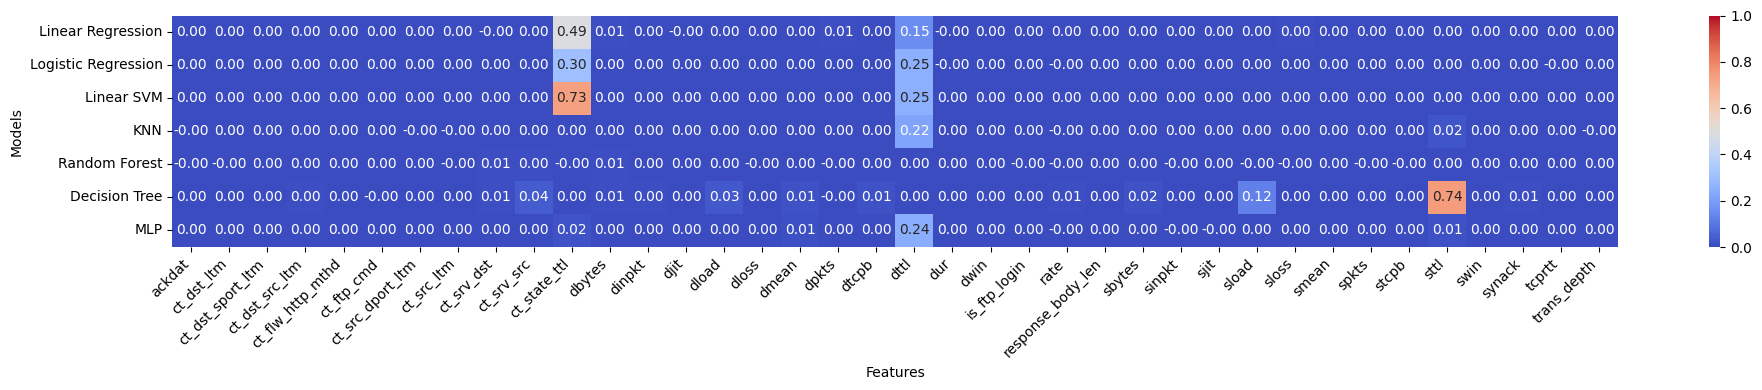

In [138]:
plt.figure(figsize=(20, 4))
sns.heatmap(df_accuracy_drops_bin, annot=True, cmap="coolwarm", fmt=".2f",vmin=0,vmax=1)
# plt.title('Occlusion Sensitivity for All Features Across Models')
plt.ylabel('Models')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')

plt.tight_layout()
plt.show()

MASKING TWO MOST IMPORTANT FEATURES

In [139]:
data = {
    'Model': [
        'Linear Regression',
        'Logistic Regression',
        'Linear SVM',
        'KNN Classifier',
        'Random Forest Classifier',
        'Decision Tree Classifier',
        'MLP Classifier'
    ],
    'Original Accuracy (%)': [
        97.86264,
        97.84416,
        97.85032,
        98.30613,
        98.63258,
        98.10902,
        98.38620
    ],
    'Masked Features': [
        "'ct_state_ttl', 'ct_dst_src_ltm'",
        "'ct_state_ttl', 'ct_dst_src_ltm'",
        "'ct_state_ttl'",
        "'ct_state_ttl', 'sttl'",
        "'sttl', 'ct_srv_src'",
        "'sttl', 'rate'",
        "'sttl', 'ct_state_ttl'"
    ],
    'New Accuracy (%)': [
        32.57161,
        26.02402,
        24.07761,
        71.06252,
        77.55467,
        24.07761,
        25.91315
    ],
    'Accuracy Drop (%)': [
        65.29103,
        71.82014,
        73.77271,
        27.24361,
        21.07791,
        74.03141,
        72.47305
    ]
}
df_masking_results = pd.DataFrame(data)
df_masking_results


,Model,Original Accuracy (%),Masked Features,New Accuracy (%),Accuracy Drop (%)
0,Linear Regression,97.86264,"'ct_state_ttl', 'ct_dst_src_ltm'",32.57161,65.29103
1,Logistic Regression,97.84416,"'ct_state_ttl', 'ct_dst_src_ltm'",26.02402,71.82014
2,Linear SVM,97.85032,'ct_state_ttl',24.07761,73.77271
3,KNN Classifier,98.30613,"'ct_state_ttl', 'sttl'",71.06252,27.24361
4,Random Forest Classifier,98.63258,"'sttl', 'ct_srv_src'",77.55467,21.07791
5,Decision Tree Classifier,98.10902,"'sttl', 'rate'",24.07761,74.03141
6,MLP Classifier,98.38620,"'sttl', 'ct_state_ttl'",25.91315,72.47305


In [140]:
models = [
    'Linear Regression',
    'Logistic Regression',
    'Linear SVM',
    'KNN Classifier',
    'Random Forest Classifier',
    'Decision Tree Classifier',
    'MLP Classifier'
]
accuracy_drop_percentages = [65.29103, 71.82014, 73.77271, 27.24361, 21.07791, 74.03141, 72.47305]
df_accuracy_drop = pd.DataFrame({
    'Model': models,
    'Accuracy Drop (%)': accuracy_drop_percentages
})
df_accuracy_drop.set_index('Model', inplace=True)
df_accuracy_drop_reshaped = df_accuracy_drop.T

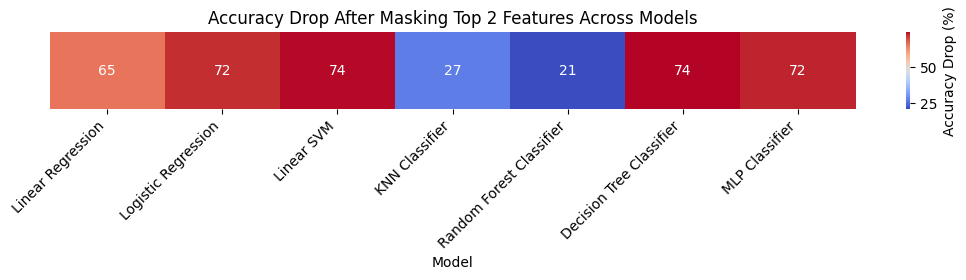

In [141]:
plt.figure(figsize=(13, 1))
sns.heatmap(df_accuracy_drop_reshaped, annot=True, cmap="coolwarm", cbar_kws={'label': 'Accuracy Drop (%)'})
plt.title('Accuracy Drop After Masking Top 2 Features Across Models')
plt.yticks([])
plt.xticks(rotation=45, ha='right')
plt.show()

# **MULTI-CLASS CLASSIFICATION**

## **Data Splitting**

In [142]:
X = multi_data.drop(columns=['label'],axis=1)
Y = multi_data['label']

In [143]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.30, random_state=100)

## **Linear Regression**

In [144]:
lr_multi = LinearRegression()

from datetime import datetime
start = datetime.now()
lr_multi.fit(X_train, y_train)
end = datetime.now()
lr_trainTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 186677.0 µs


In [145]:
from datetime import datetime
start = datetime.now()
y_preda = lr_multi.predict(X_test)
end = datetime.now()

lr_inferTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 15078.0 µs


In [146]:
for i in range(len(y_preda)):
  y_preda[i] = int(round(y_preda[i]))
# y_preda_rounded = [int(round(value)) for value in y_preda]

In [147]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_preda))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_preda))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_preda)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_preda)*100)
print("Accuracy - ",accuracy_score(y_test,y_preda)*100)

Mean Absolute Error -  3.7719694480946124
Mean Squared Error -  15.610586399474375
Root Mean Squared Error -  3.9510234622783975
R2 Score -  0.047104538980247135
Accuracy -  0.13961892247043364


In [148]:
accuracy_drop_lr_multi = []
original_accuracy_lr_multi = accuracy_score(y_test, y_preda)
print(f"Original Accuracy: {original_accuracy_lr_multi*100:.2f}%")
for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = lr_multi.predict(X_test_modified)
    y_pred_modified = [int(round(value)) for value in y_pred_modified]
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop = original_accuracy_lr_multi - new_accuracy
    accuracy_drop_lr_multi.append((feature, accuracy_drop))
print("\nOcclusion Sensitivity Analysis (Linear Regression - Multi-class):")
for feature, drop in sorted(accuracy_drop_lr_multi, key=lambda x: x[1], reverse=True):
    print(f"{feature}: Accuracy Drop = {drop:.5f}")

Original Accuracy: 0.14%

Occlusion Sensitivity Analysis (Linear Regression - Multi-class):
dttl: Accuracy Drop = 0.00008
dinpkt: Accuracy Drop = 0.00008
sjit: Accuracy Drop = 0.00008
ct_state_ttl: Accuracy Drop = 0.00008
ct_flw_http_mthd: Accuracy Drop = 0.00008
spkts: Accuracy Drop = 0.00000
sbytes: Accuracy Drop = 0.00000
dbytes: Accuracy Drop = 0.00000
rate: Accuracy Drop = 0.00000
sload: Accuracy Drop = 0.00000
dload: Accuracy Drop = 0.00000
sloss: Accuracy Drop = 0.00000
dloss: Accuracy Drop = 0.00000
djit: Accuracy Drop = 0.00000
stcpb: Accuracy Drop = 0.00000
dtcpb: Accuracy Drop = 0.00000
tcprtt: Accuracy Drop = 0.00000
ackdat: Accuracy Drop = 0.00000
smean: Accuracy Drop = 0.00000
dmean: Accuracy Drop = 0.00000
trans_depth: Accuracy Drop = 0.00000
response_body_len: Accuracy Drop = 0.00000
ct_srv_src: Accuracy Drop = 0.00000
ct_dst_ltm: Accuracy Drop = 0.00000
ct_src_dport_ltm: Accuracy Drop = 0.00000
ct_dst_sport_ltm: Accuracy Drop = 0.00000
ct_dst_src_ltm: Accuracy Drop = 0

In [149]:
accuracy_drop_lr_multi_sorted = sorted(accuracy_drop_lr_multi, key=lambda x: x[0], reverse=False)
accuracy_drop_lr_multi_sorted

[('ackdat', 0.0),
 ('ct_dst_ltm', 0.0),
 ('ct_dst_sport_ltm', 0.0),
 ('ct_dst_src_ltm', 0.0),
 ('ct_flw_http_mthd', 8.212877792378452e-05),
 ('ct_ftp_cmd', 0.0),
 ('ct_src_dport_ltm', 0.0),
 ('ct_src_ltm', -0.00016425755584756883),
 ('ct_srv_dst', -0.00016425755584756883),
 ('ct_srv_src', 0.0),
 ('ct_state_ttl', 8.212877792378452e-05),
 ('dbytes', 0.0),
 ('dinpkt', 8.212877792378452e-05),
 ('djit', 0.0),
 ('dload', 0.0),
 ('dloss', 0.0),
 ('dmean', 0.0),
 ('dpkts', -4.106438896189215e-05),
 ('dtcpb', 0.0),
 ('dttl', 8.212877792378452e-05),
 ('dur', -4.106438896189215e-05),
 ('dwin', -0.0002053219448094612),
 ('is_ftp_login', 0.0),
 ('rate', 0.0),
 ('response_body_len', 0.0),
 ('sbytes', 0.0),
 ('sinpkt', -0.00016425755584756883),
 ('sjit', 8.212877792378452e-05),
 ('sload', 0.0),
 ('sloss', 0.0),
 ('smean', 0.0),
 ('spkts', 0.0),
 ('stcpb', 0.0),
 ('sttl', -0.00016425755584756883),
 ('swin', -0.0002053219448094612),
 ('synack', -0.0002874507227332457),
 ('tcprtt', 0.0),
 ('trans_depth'

In [150]:
print(classification_report(y_test, y_preda,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       1.00      0.01      0.02       166
      Backdoor       0.00      1.00      0.00        32
           DoS       0.00      0.00      0.00       521
      Exploits       0.00      0.00      0.00      4900
       Fuzzers       0.00      0.00      0.00       508
       Generic       0.00      0.00      0.00     11839
        Normal       0.00      0.00      0.00      5855
Reconnaissance       0.00      0.00      0.00       502
         Worms       0.00      0.00      0.00        29

      accuracy                           0.00     24352
     macro avg       0.11      0.11      0.00     24352
  weighted avg       0.01      0.00      0.00     24352



c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Saving Trained Model to Disk**

In [151]:
# pkl_filename = "./models/linear_regressor_multi.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(lr_multi, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **Logistic Regression**

In [152]:
logr_multi = LogisticRegression(random_state=123, max_iter=5000,solver='newton-cg',multi_class='multinomial')

from datetime import datetime
start = datetime.now()
logr_multi.fit(X_train,y_train)
end = datetime.now()

lgr_trainTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Elapsed 7583068.0 µs


In [153]:
from datetime import datetime
start = datetime.now()
y_predb = logr_multi.predict(X_test)
end = datetime.now()

lgr_inferTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 22356.0 µs


In [154]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_predb))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_predb))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_predb)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_predb)*100)
print("Accuracy - ",accuracy_score(y_test,y_predb)*100)

Mean Absolute Error -  0.21739487516425757
Mean Squared Error -  0.6973554533508541
Root Mean Squared Error -  0.8350781121253593
R2 Score -  53.72377995229218
Accuracy -  91.22454007884363


In [155]:
accuracy_drop_logr_multi = {}
original_accuracy_logr_multi = accuracy_score(y_test, y_predb)
print(f"Original Accuracy: {original_accuracy_logr_multi*100:.2f}%")
for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = logr_multi.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop = original_accuracy_logr_multi - new_accuracy
    accuracy_drop_logr_multi[feature] = accuracy_drop
sorted_accuracy_drops = sorted(accuracy_drop_logr_multi.items(), key=lambda x: x[1], reverse=True)
print("\nOcclusion Sensitivity Analysis (Logistic Regression - Multi-class):")
for feature, drop in sorted_accuracy_drops:
  print(f"{feature}: Accuracy Drop = {drop:.5f}")
    # if drop > 0:
    #     print(f"{feature}: Accuracy Drop = {drop:.5f}")

Original Accuracy: 91.22%

Occlusion Sensitivity Analysis (Logistic Regression - Multi-class):
dttl: Accuracy Drop = 0.18528
ct_state_ttl: Accuracy Drop = 0.12853
sttl: Accuracy Drop = 0.00698
swin: Accuracy Drop = 0.00604
dwin: Accuracy Drop = 0.00604
ct_srv_dst: Accuracy Drop = 0.00501
ct_srv_src: Accuracy Drop = 0.00370
synack: Accuracy Drop = 0.00333
dur: Accuracy Drop = 0.00275
smean: Accuracy Drop = 0.00189
ct_flw_http_mthd: Accuracy Drop = 0.00181
tcprtt: Accuracy Drop = 0.00062
ct_src_ltm: Accuracy Drop = 0.00033
stcpb: Accuracy Drop = 0.00029
ct_dst_src_ltm: Accuracy Drop = 0.00029
ct_dst_ltm: Accuracy Drop = 0.00025
sload: Accuracy Drop = 0.00008
is_ftp_login: Accuracy Drop = 0.00008
ct_ftp_cmd: Accuracy Drop = 0.00008
trans_depth: Accuracy Drop = 0.00004
dload: Accuracy Drop = 0.00000
dtcpb: Accuracy Drop = 0.00000
dmean: Accuracy Drop = 0.00000
spkts: Accuracy Drop = -0.00004
sbytes: Accuracy Drop = -0.00004
dbytes: Accuracy Drop = -0.00004
sloss: Accuracy Drop = -0.00004
d

In [156]:
accuracy_drop_lgr_multi_sorted = sorted(sorted_accuracy_drops, key=lambda x: x[0], reverse=False)
accuracy_drop_lgr_multi_sorted

[('ackdat', -4.106438896189779e-05),
 ('ct_dst_ltm', 0.00024638633377138675),
 ('ct_dst_sport_ltm', -8.212877792379558e-05),
 ('ct_dst_src_ltm', 0.00028745072273328454),
 ('ct_flw_http_mthd', 0.0018068331143232808),
 ('ct_ftp_cmd', 8.212877792379558e-05),
 ('ct_src_dport_ltm', -4.106438896189779e-05),
 ('ct_src_ltm', 0.0003285151116951823),
 ('ct_srv_dst', 0.005009855453350864),
 ('ct_srv_src', 0.003695795006570357),
 ('ct_state_ttl', 0.12853153745072277),
 ('dbytes', -4.106438896189779e-05),
 ('dinpkt', -4.106438896189779e-05),
 ('djit', -4.106438896189779e-05),
 ('dload', 0.0),
 ('dloss', -4.106438896189779e-05),
 ('dmean', 0.0),
 ('dpkts', -8.212877792379558e-05),
 ('dtcpb', 0.0),
 ('dttl', 0.18528252299605785),
 ('dur', 0.002751314060446819),
 ('dwin', 0.006036465177398198),
 ('is_ftp_login', 8.212877792379558e-05),
 ('rate', -0.0004517082785807647),
 ('response_body_len', -8.212877792379558e-05),
 ('sbytes', -4.106438896189779e-05),
 ('sinpkt', -4.106438896189779e-05),
 ('sjit', -

In [157]:
X_test_modified_both = X_test.copy()
X_test_modified_both['dttl'] = 0
X_test_modified_both['swin'] = 0
y_pred_modified_both = logr_multi.predict(X_test_modified_both)
new_accuracy_both = accuracy_score(y_test, y_pred_modified_both)
drop_both = original_accuracy_logr_multi - new_accuracy_both
print(f"Original Accuracy: {original_accuracy_logr_multi*100:.2f}%")
print(f"Accuracy after masking 'dttl' and 'swin' together: {new_accuracy_both*100:.2f}% (Drop: {drop_both*100:.2f}%)")

Original Accuracy: 91.22%
Accuracy after masking 'dttl' and 'swin' together: 72.76% (Drop: 18.47%)


In [158]:
print(classification_report(y_test, y_predb,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       0.74      0.24      0.36       166
      Backdoor       0.00      0.00      0.00        32
           DoS       0.56      0.01      0.02       521
      Exploits       0.72      0.98      0.83      4900
       Fuzzers       0.71      0.43      0.54       508
       Generic       0.99      0.99      0.99     11839
        Normal       0.99      0.92      0.95      5855
Reconnaissance       0.17      0.02      0.03       502
         Worms       0.00      0.00      0.00        29

      accuracy                           0.91     24352
     macro avg       0.54      0.40      0.41     24352
  weighted avg       0.90      0.91      0.89     24352



c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [159]:
y_predb_sample = y_predb
unique_classes, counts = np.unique(y_predb_sample, return_counts=True)
class_counts = list(zip(unique_classes, counts))
sorted_class_counts = sorted(class_counts, key=lambda x: x[1], reverse=True)
df_class_ranks = pd.DataFrame(sorted_class_counts, columns=['Class', 'Count']).set_index('Class')
class_names_mapping = {
    0: 'Analysis',
    1: 'Backdoor',
    2: 'DoS',
    3: 'Exploits',
    4: 'Fuzzers',
    5: 'Generic',
    6: 'Normal',
    7: 'Reconnaissance',
    8: 'Worms'
}
df_class_ranks.index = df_class_ranks.index.map(class_names_mapping)
df_class_ranks

,Count
Class,
Generic,11805
Exploits,6653
Normal,5477
Fuzzers,307
Analysis,54
Reconnaissance,47
DoS,9


### **Saving Trained Model to Disk**

In [160]:
# pkl_filename = "./models/logistic_regressor_multi.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(logr_multi, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **Linear Support Vector Machine**

In [161]:
lsvm_multi = SVC(kernel='linear',gamma='auto')

from datetime import datetime
start = datetime.now()
lsvm_multi.fit(X_train,y_train)
end = datetime.now()
lsvm_trainTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 79825613.0 µs


In [162]:
from datetime import datetime
start = datetime.now()
y_predc = lsvm_multi.predict(X_test)
end = datetime.now()
lsvm_inferTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 25779509.0 µs


In [163]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_predc))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_predc))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_predc)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_predc)*100)
print("Accuracy - ",accuracy_score(y_test,y_predc)*100)

Mean Absolute Error -  0.2140275952693824
Mean Squared Error -  0.6804369250985546
Root Mean Squared Error -  0.8248860073358952
R2 Score -  55.040663009626954
Accuracy -  91.22454007884363


In [164]:
accuracy_drop_lsvm_multi = {}
original_accuracy_lsvm_multi = accuracy_score(y_test, y_predc)
print(f"Original Accuracy: {original_accuracy_lsvm_multi*100:.2f}%")
for feature in X.columns:
    print(feature)
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = lsvm_multi.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop = original_accuracy_lsvm_multi - new_accuracy
    accuracy_drop_lsvm_multi[feature] = accuracy_drop
sorted_accuracy_drops = sorted(accuracy_drop_lsvm_multi.items(), key=lambda x: x[1], reverse=True)

print("\nOcclusion Sensitivity Analysis (Linear SVM - Multi-class):")
for feature, drop in sorted_accuracy_drops:
    # if drop > 0:
    print(f"{feature}: Accuracy Drop = {drop*100:.2f}%")

Original Accuracy: 91.22%
dur


spkts
dpkts
sbytes
dbytes
rate
sttl
dttl
sload
dload
sloss
dloss
sinpkt
dinpkt
sjit
djit
swin
stcpb
dtcpb
dwin
tcprtt
synack
ackdat
smean
dmean
trans_depth
response_body_len
ct_srv_src
ct_state_ttl
ct_dst_ltm
ct_src_dport_ltm
ct_dst_sport_ltm
ct_dst_src_ltm
is_ftp_login
ct_ftp_cmd
ct_flw_http_mthd
ct_src_ltm
ct_srv_dst

Occlusion Sensitivity Analysis (Linear SVM - Multi-class):
ct_state_ttl: Accuracy Drop = 57.67%
sttl: Accuracy Drop = 26.22%
dttl: Accuracy Drop = 16.75%
swin: Accuracy Drop = 1.27%
dwin: Accuracy Drop = 1.27%
ct_srv_dst: Accuracy Drop = 0.60%
ct_srv_src: Accuracy Drop = 0.31%
ct_flw_http_mthd: Accuracy Drop = 0.21%
synack: Accuracy Drop = 0.15%
dur: Accuracy Drop = 0.13%
ct_dst_src_ltm: Accuracy Drop = 0.08%
is_ftp_login: Accuracy Drop = 0.04%
ct_ftp_cmd: Accuracy Drop = 0.04%
sjit: Accuracy Drop = 0.02%
smean: Accuracy Drop = 0.02%
ct_src_ltm: Accuracy Drop = 0.02%
ct_dst_sport_ltm: Accuracy Drop = 0.01%
dbytes: Accuracy Drop = 0.00%
dloss: Accuracy Drop = 0.00%
dinpk

In [165]:
accuracy_drop_lsvm_multi_sorted = sorted(accuracy_drop_lsvm_multi.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_lsvm_multi_sorted

[('ackdat', -0.0002463863337712757),
 ('ct_dst_ltm', -4.106438896189779e-05),
 ('ct_dst_sport_ltm', 8.212877792379558e-05),
 ('ct_dst_src_ltm', 0.0008212877792378448),
 ('ct_flw_http_mthd', 0.0020532194480946675),
 ('ct_ftp_cmd', 0.0004106438896189779),
 ('ct_src_dport_ltm', -0.00020532194480937793),
 ('ct_src_ltm', 0.00016425755584759116),
 ('ct_srv_dst', 0.0059954007884363),
 ('ct_srv_src', 0.0030798291721420012),
 ('ct_state_ttl', 0.5767082785808147),
 ('dbytes', 4.106438896189779e-05),
 ('dinpkt', 4.106438896189779e-05),
 ('djit', 0.0),
 ('dload', 0.0),
 ('dloss', 4.106438896189779e-05),
 ('dmean', -0.0004517082785807647),
 ('dpkts', 0.0),
 ('dtcpb', -8.212877792379558e-05),
 ('dttl', 0.16754270696452045),
 ('dur', 0.0012729960578187205),
 ('dwin', 0.01272996057818665),
 ('is_ftp_login', 0.0004106438896189779),
 ('rate', -4.106438896189779e-05),
 ('response_body_len', 0.0),
 ('sbytes', 0.0),
 ('sinpkt', 0.0),
 ('sjit', 0.00024638633377138675),
 ('sload', 0.0),
 ('sloss', 0.0),
 ('s

In [166]:
X_test_modified_both = X_test.copy()
X_test_modified_both['dttl'] = 0
X_test_modified_both['ct_state_ttl'] = 0
y_pred_modified_both = lsvm_multi.predict(X_test_modified_both)
new_accuracy_both = accuracy_score(y_test, y_pred_modified_both)
drop_both = original_accuracy_lsvm_multi - new_accuracy_both
print(f"Original Accuracy: {original_accuracy_lsvm_multi*100:.2f}%")
print(f"Accuracy after masking 'dttl' and 'ct_state_ttl' together: {new_accuracy_both*100:.2f}% (Drop: {drop_both*100:.2f}%)")

Original Accuracy: 91.22%
Accuracy after masking 'dttl' and 'ct_state_ttl' together: 26.25% (Drop: 64.98%)


In [167]:
y_predc_sample = y_predc
unique_classes, counts = np.unique(y_predc_sample, return_counts=True)
class_counts = list(zip(unique_classes, counts))
sorted_class_counts = sorted(class_counts, key=lambda x: x[1], reverse=True)
df_class_ranks = pd.DataFrame(sorted_class_counts, columns=['Class', 'Count']).set_index('Class')
class_names_mapping = {
    0: 'Analysis',
    1: 'Backdoor',
    2: 'DoS',
    3: 'Exploits',
    4: 'Fuzzers',
    5: 'Generic',
    6: 'Normal',
    7: 'Reconnaissance',
    8: 'Worms'
}
df_class_ranks.index = df_class_ranks.index.map(class_names_mapping)
df_class_ranks

,Count
Class,
Generic,11821
Exploits,6802
Normal,5453
Fuzzers,221
Analysis,51
DoS,4


In [168]:
print(classification_report(y_test, y_predc,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       0.76      0.23      0.36       166
      Backdoor       0.00      0.00      0.00        32
           DoS       0.75      0.01      0.01       521
      Exploits       0.71      0.99      0.83      4900
       Fuzzers       0.81      0.35      0.49       508
       Generic       0.99      0.99      0.99     11839
        Normal       0.99      0.92      0.96      5855
Reconnaissance       0.00      0.00      0.00       502
         Worms       0.00      0.00      0.00        29

      accuracy                           0.91     24352
     macro avg       0.56      0.39      0.40     24352
  weighted avg       0.90      0.91      0.89     24352



c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\asus\miniconda3\envs\hf-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Saving Trained Model to Disk**

In [169]:
# pkl_filename = "./models/lsvm_multi.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(lsvm_multi, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **K Nearest Neighbor Classifier**

In [170]:
knn_multi = KNeighborsClassifier(n_neighbors=5)

from datetime import datetime
start = datetime.now()
knn_multi.fit(X_train,y_train)
end = datetime.now()

knn_trainTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 274955.0 µs


In [171]:
from datetime import datetime
start = datetime.now()
y_predd = knn_multi.predict(X_test)
end = datetime.now()

knn_inferTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 9187639.0 µs


In [172]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_predd))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_predd))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_predd)))
print("Accuracy - ",accuracy_score(y_test,y_predd)*100)

Mean Absolute Error -  0.241622864651774
Mean Squared Error -  0.8492115637319316
Root Mean Squared Error -  0.921526756926749
Accuracy -  90.97404730617609


In [173]:
accuracy_drop_knn_multi = {}
original_accuracy_knn_multi = accuracy_score(y_test, y_predd)
print(f"Original Accuracy: {original_accuracy_knn_multi*100:.2f}%")
for feature in X.columns:
    print(feature)
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = knn_multi.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop = original_accuracy_knn_multi - new_accuracy
    accuracy_drop_knn_multi[feature] = accuracy_drop
sorted_accuracy_drops = sorted(accuracy_drop_knn_multi.items(), key=lambda x: x[1], reverse=True)
print("\nOcclusion Sensitivity Analysis (KNN - Multi-class):")
for feature, drop in sorted_accuracy_drops:
    # if drop > 0:
    print(f"{feature}: Accuracy Drop = {drop*100:.2f}%")

Original Accuracy: 90.97%
dur
spkts
dpkts
sbytes
dbytes
rate
sttl
dttl
sload
dload
sloss
dloss
sinpkt
dinpkt
sjit
djit
swin
stcpb
dtcpb
dwin
tcprtt
synack
ackdat
smean
dmean
trans_depth
response_body_len
ct_srv_src
ct_state_ttl
ct_dst_ltm
ct_src_dport_ltm
ct_dst_sport_ltm
ct_dst_src_ltm
is_ftp_login
ct_ftp_cmd
ct_flw_http_mthd
ct_src_ltm
ct_srv_dst

Occlusion Sensitivity Analysis (KNN - Multi-class):
sttl: Accuracy Drop = 39.68%
dttl: Accuracy Drop = 16.09%
dmean: Accuracy Drop = 1.01%
smean: Accuracy Drop = 0.99%
dtcpb: Accuracy Drop = 0.52%
ct_srv_src: Accuracy Drop = 0.51%
ct_srv_dst: Accuracy Drop = 0.49%
synack: Accuracy Drop = 0.45%
ct_state_ttl: Accuracy Drop = 0.44%
ct_dst_src_ltm: Accuracy Drop = 0.29%
rate: Accuracy Drop = 0.18%
dur: Accuracy Drop = 0.10%
is_ftp_login: Accuracy Drop = 0.09%
ct_ftp_cmd: Accuracy Drop = 0.09%
tcprtt: Accuracy Drop = 0.07%
ct_flw_http_mthd: Accuracy Drop = 0.06%
sload: Accuracy Drop = 0.04%
ackdat: Accuracy Drop = 0.03%
sinpkt: Accuracy Drop = 0

In [174]:
accuracy_drop_knn_multi_sorted = sorted(accuracy_drop_knn_multi.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_knn_multi_sorted

[('ackdat', 0.00028745072273328454),
 ('ct_dst_ltm', -0.0002463863337712757),
 ('ct_dst_sport_ltm', -0.00020532194480948895),
 ('ct_dst_src_ltm', 0.00291557161629441),
 ('ct_flw_http_mthd', 0.0005749014454665691),
 ('ct_ftp_cmd', 0.0009034165571616404),
 ('ct_src_dport_ltm', -0.00020532194480948895),
 ('ct_src_ltm', -0.0004927726675426625),
 ('ct_srv_dst', 0.004886662286465171),
 ('ct_srv_src', 0.00509198423127466),
 ('ct_state_ttl', 0.004352825229960611),
 ('dbytes', -8.212877792379558e-05),
 ('dinpkt', 4.106438896189779e-05),
 ('djit', 0.0),
 ('dload', 0.0),
 ('dloss', -8.212877792379558e-05),
 ('dmean', 0.010060775295663626),
 ('dpkts', -8.212877792379558e-05),
 ('dtcpb', 0.005215177398160353),
 ('dttl', 0.1608902759526939),
 ('dur', 0.0010266097240473337),
 ('dwin', 4.106438896189779e-05),
 ('is_ftp_login', 0.0009034165571616404),
 ('rate', 0.0018068331143232808),
 ('response_body_len', -0.00012319316688569337),
 ('sbytes', 8.212877792379558e-05),
 ('sinpkt', 0.00020532194480948895

In [175]:
X_test_modified_both = X_test.copy()
X_test_modified_both['dttl'] = 0
X_test_modified_both['swin'] = 0
y_pred_modified_both = knn_multi.predict(X_test_modified_both)
new_accuracy_both = accuracy_score(y_test, y_pred_modified_both)
drop_both = original_accuracy_knn_multi - new_accuracy_both
print(f"Original Accuracy: {original_accuracy_knn_multi*100:.2f}%")
print(f"Accuracy after masking 'dttl' and 'swin' together: {new_accuracy_both*100:.2f}% (Drop: {drop_both*100:.2f}%)")

Original Accuracy: 90.97%
Accuracy after masking 'dttl' and 'swin' together: 73.74% (Drop: 17.24%)


In [176]:
y_predd_sample = y_predd
unique_classes, counts = np.unique(y_predd_sample, return_counts=True)
class_counts = list(zip(unique_classes, counts))
sorted_class_counts = sorted(class_counts, key=lambda x: x[1], reverse=True)
df_class_ranks = pd.DataFrame(sorted_class_counts, columns=['Class', 'Count']).set_index('Class')
class_names_mapping = {
    0: 'Analysis',
    1: 'Backdoor',
    2: 'DoS',
    3: 'Exploits',
    4: 'Fuzzers',
    5: 'Generic',
    6: 'Normal',
    7: 'Reconnaissance',
    8: 'Worms'
}
df_class_ranks.index = df_class_ranks.index.map(class_names_mapping)

df_class_ranks

,Count
Class,
Generic,11742
Exploits,5714
Normal,5619
Reconnaissance,437
Fuzzers,427
DoS,254
Analysis,135
Backdoor,14
Worms,10


In [177]:
 print(classification_report(y_test, y_predd,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       0.49      0.40      0.44       166
      Backdoor       0.14      0.06      0.09        32
           DoS       0.20      0.10      0.13       521
      Exploits       0.78      0.90      0.84      4900
       Fuzzers       0.66      0.55      0.60       508
       Generic       1.00      0.99      0.99     11839
        Normal       0.97      0.93      0.95      5855
Reconnaissance       0.28      0.24      0.26       502
         Worms       0.30      0.10      0.15        29

      accuracy                           0.91     24352
     macro avg       0.54      0.48      0.49     24352
  weighted avg       0.90      0.91      0.90     24352



### **Saving Trained Model to Disk**

In [178]:
# pkl_filename = "./models/knn_multi.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(knn_multi, file)
#   print("Saved model to disk")
# else:zx
#   print("Model already saved")

## **Random Forest Classifier**

In [179]:
rf_multi = RandomForestClassifier(random_state=50)

from datetime import datetime
start = datetime.now()
rf_multi.fit(X_train,y_train)
end = datetime.now()

rf_trainTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 24265503.0 µs


In [180]:

from datetime import datetime
start = datetime.now()
y_prede = rf_multi.predict(X_test)
end = datetime.now()

rf_inferTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 611517.0 µs


In [181]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_prede))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_prede))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_prede)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_prede)*100)
print("Accuracy - ",accuracy_score(y_test,y_prede)*100)

Mean Absolute Error -  0.146723061760841
Mean Squared Error -  0.5271435611038108
Root Mean Squared Error -  0.7260465281948608
R2 Score -  64.50307843858147
Accuracy -  94.55486202365309


In [182]:
accuracy_drop_rf_multi = {}
original_accuracy_rf_multi = accuracy_score(y_test, y_prede)
for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = rf_multi.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop = original_accuracy_rf_multi - new_accuracy
    accuracy_drop_rf_multi[feature] = accuracy_drop
sorted_accuracy_drops = sorted(accuracy_drop_rf_multi.items(), key=lambda x: x[1], reverse=True)
print("Occlusion Sensitivity Analysis (Random Forest - Multi-class):")
for feature, drop in sorted_accuracy_drops:
    # if drop > 0:
      print(f"{feature}: Accuracy Drop = {drop*100:.2f}%")

Occlusion Sensitivity Analysis (Random Forest - Multi-class):
sttl: Accuracy Drop = 1.31%
sbytes: Accuracy Drop = 1.05%
ct_srv_dst: Accuracy Drop = 0.97%
dbytes: Accuracy Drop = 0.94%
smean: Accuracy Drop = 0.64%
ct_srv_src: Accuracy Drop = 0.57%
synack: Accuracy Drop = 0.52%
tcprtt: Accuracy Drop = 0.45%
ackdat: Accuracy Drop = 0.41%
ct_dst_src_ltm: Accuracy Drop = 0.31%
dmean: Accuracy Drop = 0.24%
response_body_len: Accuracy Drop = 0.18%
spkts: Accuracy Drop = 0.17%
djit: Accuracy Drop = 0.15%
stcpb: Accuracy Drop = 0.15%
sinpkt: Accuracy Drop = 0.14%
sloss: Accuracy Drop = 0.13%
ct_flw_http_mthd: Accuracy Drop = 0.13%
dloss: Accuracy Drop = 0.11%
sload: Accuracy Drop = 0.11%
trans_depth: Accuracy Drop = 0.09%
dtcpb: Accuracy Drop = 0.08%
dttl: Accuracy Drop = 0.07%
dpkts: Accuracy Drop = 0.06%
dload: Accuracy Drop = 0.05%
rate: Accuracy Drop = 0.04%
dinpkt: Accuracy Drop = 0.03%
ct_dst_ltm: Accuracy Drop = 0.02%
sjit: Accuracy Drop = 0.02%
dwin: Accuracy Drop = 0.01%
dur: Accuracy 

In [183]:
accuracy_drop_rf_multi_sorted = sorted(accuracy_drop_rf_multi.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_rf_multi_sorted

[('ackdat', 0.004147503285151122),
 ('ct_dst_ltm', 0.00020532194480948895),
 ('ct_dst_sport_ltm', -8.212877792379558e-05),
 ('ct_dst_src_ltm', 0.0030798291721418902),
 ('ct_flw_http_mthd', 0.0013140604467805073),
 ('ct_ftp_cmd', 4.106438896189779e-05),
 ('ct_src_dport_ltm', -8.212877792379558e-05),
 ('ct_src_ltm', -0.00028745072273328454),
 ('ct_srv_dst', 0.009691195795006546),
 ('ct_srv_src', 0.005666885676741118),
 ('ct_state_ttl', 0.0),
 ('dbytes', 0.009403745072273262),
 ('dinpkt', 0.0003285151116950713),
 ('djit', 0.0015193823915899962),
 ('dload', 0.0004517082785807647),
 ('dloss', 0.0011087385019710183),
 ('dmean', 0.0024227989487516366),
 ('dpkts', 0.000574901445466458),
 ('dtcpb', 0.0008212877792378448),
 ('dttl', 0.0007391590013140492),
 ('dur', 4.106438896189779e-05),
 ('dwin', 8.212877792379558e-05),
 ('is_ftp_login', -4.106438896189779e-05),
 ('rate', 0.0003695795006569691),
 ('response_body_len', 0.0018478975032851785),
 ('sbytes', 0.010512483574244391),
 ('sinpkt', 0.001

In [184]:
X_test_modified_single = X_test.copy()
X_test_modified_single['dttl'] = 0
y_pred_modified_single = rf_multi.predict(X_test_modified_single)
new_accuracy_single = accuracy_score(y_test, y_pred_modified_single)
drop_single = original_accuracy_rf_multi - new_accuracy_single
print(f"Original Accuracy: {original_accuracy_rf_multi*100:.2f}%")
print(f"Accuracy after masking the most important feature 'dttl': {new_accuracy_single*100:.2f}% (Drop: {drop_single*100:.2f}%)")

Original Accuracy: 94.55%
Accuracy after masking the most important feature 'dttl': 94.48% (Drop: 0.07%)


In [185]:
print(classification_report(y_test, y_prede,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       0.79      0.48      0.59       166
      Backdoor       0.89      0.25      0.39        32
           DoS       0.65      0.31      0.42       521
      Exploits       0.86      0.94      0.90      4900
       Fuzzers       0.76      0.85      0.80       508
       Generic       1.00      0.99      1.00     11839
        Normal       0.98      0.97      0.97      5855
Reconnaissance       0.60      0.56      0.58       502
         Worms       0.46      0.38      0.42        29

      accuracy                           0.95     24352
     macro avg       0.78      0.64      0.67     24352
  weighted avg       0.94      0.95      0.94     24352



### **Saving Trained Model to Disk**

In [186]:
# pkl_filename = "./models/random_forest_multi.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(rf_multi, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **Decision Tree Classifier**

In [187]:
dt_multi = DecisionTreeClassifier(random_state=123)

from datetime import datetime
start = datetime.now()
dt_multi.fit(X_train,y_train)
end = datetime.now()
dt_trainTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 1867138.0 µs


In [188]:
from datetime import datetime
start = datetime.now()
y_predf = dt_multi.predict(X_test)
end = datetime.now()
dt_inferTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 13998.0 µs


In [189]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_predf))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_predf))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_predf)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_predf)*100)
print("Accuracy - ",accuracy_score(y_test,y_predf)*100)

Mean Absolute Error -  0.18984067017082787
Mean Squared Error -  0.6799852168199737
Root Mean Squared Error -  0.8246121614552951
R2 Score -  54.20906192612218
Accuracy -  92.73570959264126


In [190]:
accuracy_drop_dt_multi = {}
original_accuracy_dt_multi = accuracy_score(y_test, y_predf)

for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = dt_multi.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop_dt_multi[feature] = original_accuracy_dt_multi - new_accuracy

sorted_accuracy_drops_dt = sorted(accuracy_drop_dt_multi.items(), key=lambda x: x[1], reverse=True)

for feature, drop in sorted_accuracy_drops_dt:
    print(f"{feature}: Accuracy Drop = {drop*100:.2f}%")

sbytes: Accuracy Drop = 80.10%
sload: Accuracy Drop = 49.08%
sttl: Accuracy Drop = 20.53%
dbytes: Accuracy Drop = 8.89%
smean: Accuracy Drop = 3.85%
rate: Accuracy Drop = 3.84%
dinpkt: Accuracy Drop = 3.56%
dload: Accuracy Drop = 3.45%
synack: Accuracy Drop = 3.20%
djit: Accuracy Drop = 2.49%
dtcpb: Accuracy Drop = 2.34%
dmean: Accuracy Drop = 2.28%
tcprtt: Accuracy Drop = 2.17%
dur: Accuracy Drop = 1.62%
sjit: Accuracy Drop = 1.37%
spkts: Accuracy Drop = 1.33%
ct_srv_dst: Accuracy Drop = 1.25%
ct_srv_src: Accuracy Drop = 1.24%
ackdat: Accuracy Drop = 1.11%
response_body_len: Accuracy Drop = 1.06%
stcpb: Accuracy Drop = 0.97%
ct_flw_http_mthd: Accuracy Drop = 0.84%
sinpkt: Accuracy Drop = 0.60%
ct_dst_src_ltm: Accuracy Drop = 0.37%
dloss: Accuracy Drop = 0.24%
ct_src_ltm: Accuracy Drop = 0.11%
sloss: Accuracy Drop = 0.11%
dpkts: Accuracy Drop = 0.08%
trans_depth: Accuracy Drop = 0.04%
ct_src_dport_ltm: Accuracy Drop = 0.03%
is_ftp_login: Accuracy Drop = 0.01%
ct_dst_sport_ltm: Accuracy

In [191]:
accuracy_drop_dt_multi_sorted = sorted(accuracy_drop_dt_multi.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_dt_multi_sorted

[('ackdat', 0.011128449408672747),
 ('ct_dst_ltm', -0.00012319316688569337),
 ('ct_dst_sport_ltm', 4.106438896189779e-05),
 ('ct_dst_src_ltm', 0.0036547306176083483),
 ('ct_flw_http_mthd', 0.008377135348225928),
 ('ct_ftp_cmd', 4.106438896189779e-05),
 ('ct_src_dport_ltm', 0.0003285151116950713),
 ('ct_src_ltm', 0.001149802890932916),
 ('ct_srv_dst', 0.01252463863337705),
 ('ct_srv_src', 0.01236038107752957),
 ('ct_state_ttl', 0.0),
 ('dbytes', 0.08886333771353483),
 ('dinpkt', 0.0355617608409986),
 ('djit', 0.024926084099868517),
 ('dload', 0.034453022339027584),
 ('dloss', 0.0024227989487516366),
 ('dmean', 0.022790735873850165),
 ('dpkts', 0.000780223390275947),
 ('dtcpb', 0.023365637319316623),
 ('dttl', 0.0),
 ('dur', 0.01617936925098551),
 ('dwin', 0.0),
 ('is_ftp_login', 8.212877792379558e-05),
 ('rate', 0.03835413929040732),
 ('response_body_len', 0.010594612352168187),
 ('sbytes', 0.8009609067017083),
 ('sinpkt', 0.005995400788436189),
 ('sjit', 0.013715505913271975),
 ('sload

In [192]:
X_test_modified_both_dt = X_test.copy()
X_test_modified_both_dt[sorted_accuracy_drops_dt[0][0]] = 0
X_test_modified_both_dt[sorted_accuracy_drops_dt[1][0]] = 0
y_pred_modified_both_dt = dt_multi.predict(X_test_modified_both_dt)
new_accuracy_both_dt = accuracy_score(y_test, y_pred_modified_both_dt)
drop_both_dt = original_accuracy_dt_multi - new_accuracy_both_dt
print(f"Original Accuracy: {original_accuracy_dt_multi*100:.2f}%")
print(f"Accuracy after masking '{sorted_accuracy_drops_dt[0][0]}' and '{sorted_accuracy_drops_dt[1][0]}' together: {new_accuracy_both_dt*100:.2f}% (Drop: {drop_both_dt*100:.2f}%)")

Original Accuracy: 92.74%
Accuracy after masking 'sbytes' and 'sload' together: 12.71% (Drop: 80.02%)


In [193]:
y_predf_sample = y_predf  # Use your actual predictions here
unique_classes_dt, counts_dt = np.unique(y_predf_sample, return_counts=True)
class_counts_dt = list(zip(unique_classes_dt, counts_dt))
sorted_class_counts_dt = sorted(class_counts_dt, key=lambda x: x[1], reverse=True)
df_class_ranks_dt = pd.DataFrame(sorted_class_counts_dt, columns=['Class', 'Count']).set_index('Class')
df_class_ranks_dt.index = df_class_ranks_dt.index.map(class_names_mapping)
df_class_ranks_dt

,Count
Class,
Generic,11843
Normal,5834
Exploits,4827
DoS,605
Fuzzers,531
Reconnaissance,485
Analysis,161
Worms,45
Backdoor,21


In [194]:
print(classification_report(y_test, y_predf,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       0.58      0.56      0.57       166
      Backdoor       0.33      0.22      0.26        32
           DoS       0.35      0.40      0.37       521
      Exploits       0.87      0.86      0.87      4900
       Fuzzers       0.72      0.75      0.73       508
       Generic       0.99      1.00      0.99     11839
        Normal       0.97      0.96      0.96      5855
Reconnaissance       0.50      0.48      0.49       502
         Worms       0.42      0.66      0.51        29

      accuracy                           0.93     24352
     macro avg       0.64      0.65      0.64     24352
  weighted avg       0.93      0.93      0.93     24352



### **Saving Trained Model to Disk**

In [195]:
# pkl_filename = "./models/decision_tree_multi.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(dt_multi, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

## **Multi Layer Perceptron**

In [196]:
mlp_multi = MLPClassifier(random_state=123, solver='adam', max_iter=8000)

from datetime import datetime
start = datetime.now()
mlp_multi.fit(X_train,y_train)
end = datetime.now()

mlp_trainTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

Elapsed 341485277.0 µs


In [197]:

from datetime import datetime
start = datetime.now()
y_predg = mlp_multi.predict(X_test)
end = datetime.now()

mlp_inferTime_mul = end - start
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


Elapsed 161451.0 µs


In [198]:
print("Mean Absolute Error - " , metrics.mean_absolute_error(y_test, y_predg))
print("Mean Squared Error - " , metrics.mean_squared_error(y_test, y_predg))
print("Root Mean Squared Error - " , np.sqrt(metrics.mean_squared_error(y_test, y_predg)))
print("R2 Score - " , metrics.explained_variance_score(y_test, y_predg)*100)
print("Accuracy - ",accuracy_score(y_test,y_predg)*100)

Mean Absolute Error -  0.1699244415243101
Mean Squared Error -  0.5860709592641261
Root Mean Squared Error -  0.7655527148826043
R2 Score -  60.57111071633747
Accuracy -  93.43791064388962


In [199]:
accuracy_drop_mlp_multi = {}
original_accuracy_mlp_multi = accuracy_score(y_test, y_predg)

for feature in X.columns:
    X_test_modified = X_test.copy()
    X_test_modified[feature] = 0
    y_pred_modified = mlp_multi.predict(X_test_modified)
    new_accuracy = accuracy_score(y_test, y_pred_modified)
    accuracy_drop_mlp_multi[feature] = original_accuracy_mlp_multi - new_accuracy

sorted_accuracy_drops_mlp = sorted(accuracy_drop_mlp_multi.items(), key=lambda x: x[1], reverse=True)

for feature, drop in sorted_accuracy_drops_mlp:
    print(f"{feature}: Accuracy Drop = {drop*100:.2f}%")

ct_dst_src_ltm: Accuracy Drop = 40.74%
ct_srv_dst: Accuracy Drop = 35.71%
sttl: Accuracy Drop = 23.92%
dttl: Accuracy Drop = 19.93%
dmean: Accuracy Drop = 4.71%
smean: Accuracy Drop = 3.25%
ct_state_ttl: Accuracy Drop = 2.80%
dwin: Accuracy Drop = 1.62%
swin: Accuracy Drop = 1.10%
dur: Accuracy Drop = 0.70%
ct_flw_http_mthd: Accuracy Drop = 0.55%
ct_srv_src: Accuracy Drop = 0.34%
synack: Accuracy Drop = 0.27%
rate: Accuracy Drop = 0.17%
ackdat: Accuracy Drop = 0.16%
sjit: Accuracy Drop = 0.13%
tcprtt: Accuracy Drop = 0.11%
ct_src_ltm: Accuracy Drop = 0.09%
sinpkt: Accuracy Drop = 0.08%
dinpkt: Accuracy Drop = 0.08%
sload: Accuracy Drop = 0.05%
dtcpb: Accuracy Drop = 0.04%
ct_dst_ltm: Accuracy Drop = 0.04%
spkts: Accuracy Drop = 0.03%
dpkts: Accuracy Drop = 0.02%
djit: Accuracy Drop = 0.02%
sbytes: Accuracy Drop = 0.02%
dloss: Accuracy Drop = 0.02%
ct_ftp_cmd: Accuracy Drop = 0.01%
dbytes: Accuracy Drop = 0.01%
dload: Accuracy Drop = 0.01%
is_ftp_login: Accuracy Drop = 0.01%
sloss: Accu

In [200]:
accuracy_drop_mlp_multi_sorted = sorted(accuracy_drop_mlp_multi.items(), key=lambda x: x[0], reverse=False)
accuracy_drop_mlp_multi_sorted

[('ackdat', 0.0016015111695137918),
 ('ct_dst_ltm', 0.0003695795006570801),
 ('ct_dst_sport_ltm', 0.0),
 ('ct_dst_src_ltm', 0.407399802890933),
 ('ct_flw_http_mthd', 0.005543692509855425),
 ('ct_ftp_cmd', 0.00012319316688569337),
 ('ct_src_dport_ltm', -0.00016425755584759116),
 ('ct_src_ltm', 0.0008623521681997426),
 ('ct_srv_dst', 0.3570548620236531),
 ('ct_srv_src', 0.0034083442838370726),
 ('ct_state_ttl', 0.028046977660972416),
 ('dbytes', 8.212877792379558e-05),
 ('dinpkt', 0.000780223390275947),
 ('djit', 0.00024638633377138675),
 ('dload', 8.212877792379558e-05),
 ('dloss', 0.00016425755584759116),
 ('dmean', 0.047141918528252336),
 ('dpkts', 0.00024638633377138675),
 ('dtcpb', 0.0003695795006570801),
 ('dttl', 0.1992854796320631),
 ('dur', 0.007022010512483634),
 ('dwin', 0.016220433639947407),
 ('is_ftp_login', 8.212877792379558e-05),
 ('rate', 0.0016836399474375874),
 ('response_body_len', -8.212877792379558e-05),
 ('sbytes', 0.00016425755584759116),
 ('sinpkt', 0.00078022339

In [201]:
X_test_modified_both_mlp = X_test.copy()
X_test_modified_both_mlp[sorted_accuracy_drops_mlp[0][0]] = 0
X_test_modified_both_mlp[sorted_accuracy_drops_mlp[1][0]] = 0
y_pred_modified_both_mlp = mlp_multi.predict(X_test_modified_both_mlp)
new_accuracy_both_mlp = accuracy_score(y_test, y_pred_modified_both_mlp)
drop_both_mlp = original_accuracy_mlp_multi - new_accuracy_both_mlp
print(f"Original Accuracy: {original_accuracy_mlp_multi*100:.2f}%")
print(f"Accuracy after masking '{sorted_accuracy_drops_mlp[0][0]}' and '{sorted_accuracy_drops_mlp[1][0]}' together: {new_accuracy_both_mlp*100:.2f}% (Drop: {drop_both_mlp*100:.2f}%)")


Original Accuracy: 93.44%
Accuracy after masking 'ct_dst_src_ltm' and 'ct_srv_dst' together: 44.23% (Drop: 49.21%)


In [202]:
y_predg_sample = y_predg
unique_classes_mlp, counts_mlp = np.unique(y_predg_sample, return_counts=True)
class_counts_mlp = list(zip(unique_classes_mlp, counts_mlp))
sorted_class_counts_mlp = sorted(class_counts_mlp, key=lambda x: x[1], reverse=True)
df_class_ranks_mlp = pd.DataFrame(sorted_class_counts_mlp, columns=['Class', 'Count']).set_index('Class')
df_class_ranks_mlp.index = df_class_ranks_mlp.index.map(class_names_mapping)
df_class_ranks_mlp

,Count
Class,
Generic,11735
Normal,5757
Exploits,5706
Fuzzers,525
Reconnaissance,355
DoS,155
Analysis,108
Worms,8
Backdoor,3


In [203]:
print(classification_report(y_test, y_predg,target_names=le2.classes_))

                precision    recall  f1-score   support

      Analysis       0.64      0.42      0.50       166
      Backdoor       0.67      0.06      0.11        32
           DoS       0.57      0.17      0.26       521
      Exploits       0.82      0.96      0.88      4900
       Fuzzers       0.69      0.71      0.70       508
       Generic       1.00      0.99      0.99     11839
        Normal       0.97      0.96      0.96      5855
Reconnaissance       0.63      0.45      0.52       502
         Worms       0.38      0.10      0.16        29

      accuracy                           0.93     24352
     macro avg       0.71      0.53      0.57     24352
  weighted avg       0.93      0.93      0.93     24352



In [204]:
# pkl_filename = "./models/mlp_multi.pkl"
# if (not path.isfile(pkl_filename)):
#   # saving the trained model to disk
#   with open(pkl_filename, 'wb') as file:
#     pickle.dump(mlp_multi, file)
#   print("Saved model to disk")
# else:
#   print("Model already saved")

In [205]:
fullFeatureNames = []
for item in accuracy_drop_lr_multi_sorted:
  fullFeatureNames.append(item[0])

def extractValues(accuracyDropList):
  valList = []
  for item in accuracyDropList:
    valList.append(item[1])
  # print(len(valList))
  return valList

fullFeatureaccuracy_drops = {
    'Linear Regression': extractValues(accuracy_drop_lr_multi_sorted),
    'Logistic Regression': extractValues(accuracy_drop_lgr_multi_sorted),
    'Linear SVM': extractValues(accuracy_drop_lsvm_multi_sorted),
    'KNN': extractValues(accuracy_drop_knn_multi_sorted),
    'Random Forest': extractValues(accuracy_drop_rf_multi_sorted),
    'Decision Tree': extractValues(accuracy_drop_dt_multi_sorted),
    'MLP': extractValues(accuracy_drop_mlp_multi_sorted),
}

df_accuracy_drops_mul = pd.DataFrame(fullFeatureaccuracy_drops, index=fullFeatureNames)
df_accuracy_drops_mul = df_accuracy_drops_mul.T
df_accuracy_drops_mul


,ackdat,ct_dst_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_flw_http_mthd,ct_ftp_cmd,ct_src_dport_ltm,ct_src_ltm,ct_srv_dst,ct_srv_src,...,sload,sloss,smean,spkts,stcpb,sttl,swin,synack,tcprtt,trans_depth
Linear Regression,0.000000,0.000000,0.000000,0.000000,0.000082,0.000000,0.000000,-0.000164,-0.000164,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000164,-0.000205,-0.000287,0.000000,0.000000
Logistic Regression,-0.000041,0.000246,-0.000082,0.000287,0.001807,0.000082,-0.000041,0.000329,0.005010,0.003696,...,0.000082,-0.000041,0.001889,-0.000041,0.000287,0.006981,0.006036,0.003326,0.000616,0.000041
Linear SVM,-0.000246,-0.000041,0.000082,0.000821,0.002053,0.000411,-0.000205,0.000164,0.005995,0.003080,...,0.000000,0.000000,0.000164,0.000000,0.000041,0.262155,0.012730,0.001519,0.000000,0.000041
KNN,0.000287,-0.000246,-0.000205,0.002916,0.000575,0.000903,-0.000205,-0.000493,0.004887,0.005092,...,0.000370,0.000123,0.009855,0.000082,-0.000493,0.396846,0.000041,0.004476,0.000739,-0.000041
Random Forest,0.004148,0.000205,-0.000082,0.003080,0.001314,0.000041,-0.000082,-0.000287,0.009691,0.005667,...,0.001068,0.001314,0.006365,0.001684,0.001478,0.013100,0.000000,0.005174,0.004476,0.000903
Decision Tree,0.011128,-0.000123,0.000041,0.003655,0.008377,0.000041,0.000329,0.001150,0.012525,0.012360,...,0.490761,0.001068,0.038518,0.013346,0.009691,0.205322,0.000000,0.032030,0.021723,0.000370
MLP,0.001602,0.000370,0.000000,0.407400,0.005544,0.000123,-0.000164,0.000862,0.357055,0.003408,...,0.000493,0.000000,0.032482,0.000329,-0.001273,0.239241,0.010964,0.002669,0.001150,-0.000205


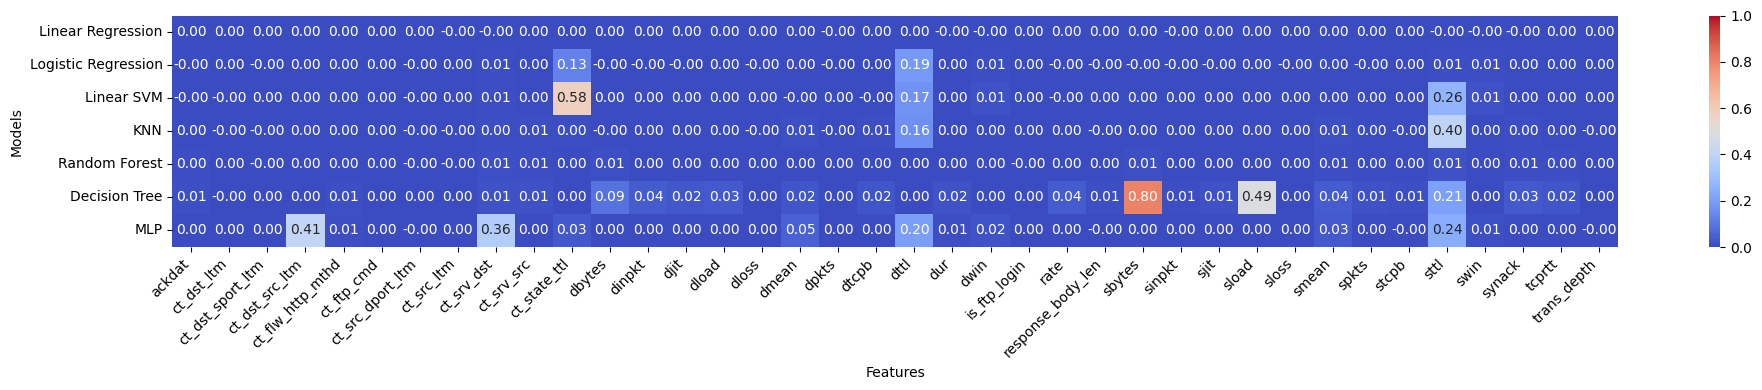

In [206]:
plt.figure(figsize=(20, 4))
sns.heatmap(df_accuracy_drops_mul, annot=True, cmap="coolwarm", fmt=".2f",vmin=0,vmax=1)
# plt.title('Occlusion Sensitivity for All Features Across Models')
plt.ylabel('Models')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')

plt.tight_layout()
plt.show()

In [207]:
[lr_trainTime_bin., lgr_trainTime_bin, lsvm_trainTime_bin, knn_trainTime_bin, rf_trainTime_bin, dt_trainTime_bin,
                                 mlp_trainTime_bin]

SyntaxError: invalid syntax (1780984019.py, line 1)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Logistic Regression'),
  Text(2, 0, 'Linear SVM'),
  Text(3, 0, 'K-NN'),
  Text(4, 0, 'Random Forest'),
  Text(5, 0, 'Decision Tree'),
  Text(6, 0, 'MLP')])

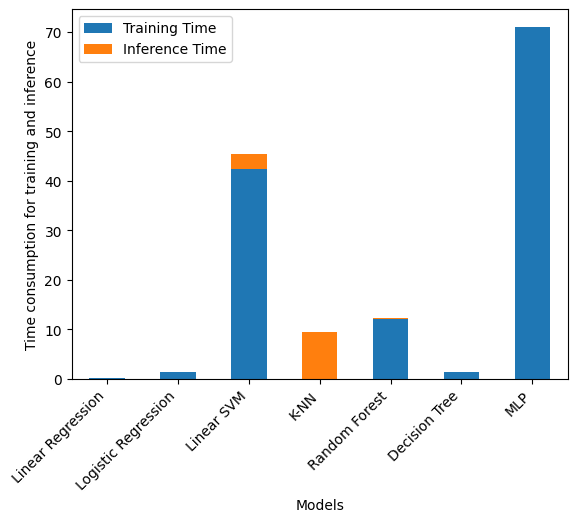

In [ ]:
# create DataFrame
df = pd.DataFrame({'Binary Classifier Training Time': [lr_trainTime_bin.total_seconds(), lgr_trainTime_bin.total_seconds(), lsvm_trainTime_bin.total_seconds(), knn_trainTime_bin.total_seconds(), rf_trainTime_bin.total_seconds(), dt_trainTime_bin.total_seconds(),
                                 mlp_trainTime_bin.total_seconds()],
                   'Binary Classifier Inference Time': [lr_inferTime_bin.total_seconds(), lgr_inferTime_bin.total_seconds(), lsvm_inferTime_bin.total_seconds(), knn_inferTime_bin.total_seconds(), rf_inferTime_bin.total_seconds(), dt_inferTime_bin.total_seconds(),
                                 mlp_inferTime_bin.total_seconds()]},
                  index=['Linear Regression', 'Logistic Regression', 'Linear SVM', 'K-NN', 'Random Forest',
                         'Decision Tree', 'MLP'])


# create stacked bar chart for monthly temperatures
df.plot(kind='bar', stacked=True)

# labels for x & y axis
plt.xlabel('Models')
plt.ylabel('Time consumption for training and inference')

plt.xticks(rotation=45, ha='right')


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Logistic Regression'),
  Text(2, 0, 'Linear SVM'),
  Text(3, 0, 'K-NN'),
  Text(4, 0, 'Random Forest'),
  Text(5, 0, 'Decision Tree'),
  Text(6, 0, 'MLP')])

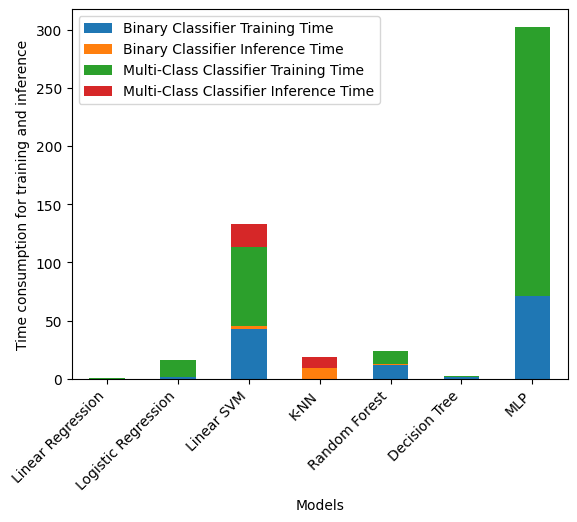

In [ ]:
# create DataFrame
df = pd.DataFrame({'Binary Classifier Training Time': [lr_trainTime_bin.total_seconds(), lgr_trainTime_bin.total_seconds(), lsvm_trainTime_bin.total_seconds(), knn_trainTime_bin.total_seconds(), rf_trainTime_bin.total_seconds(), dt_trainTime_bin.total_seconds(),
                                 mlp_trainTime_bin.total_seconds()],
                   'Binary Classifier Inference Time': [lr_inferTime_bin.total_seconds(), lgr_inferTime_bin.total_seconds(), lsvm_inferTime_bin.total_seconds(), knn_inferTime_bin.total_seconds(), rf_inferTime_bin.total_seconds(), dt_inferTime_bin.total_seconds(),
                                 mlp_inferTime_bin.total_seconds()],
                   'Multi-Class Classifier Training Time': [lr_trainTime_mul.total_seconds(), lgr_trainTime_mul.total_seconds(), lsvm_trainTime_mul.total_seconds(), knn_trainTime_mul.total_seconds(), rf_trainTime_mul.total_seconds(), dt_trainTime_mul.total_seconds(),
                                 mlp_trainTime_mul.total_seconds()],
                   'Multi-Class Classifier Inference Time': [lr_inferTime_mul.total_seconds(), lgr_inferTime_mul.total_seconds(), lsvm_inferTime_mul.total_seconds(), knn_inferTime_bin.total_seconds(), rf_inferTime_mul.total_seconds(), dt_inferTime_mul.total_seconds(),
                                 mlp_inferTime_mul.total_seconds()]},
                  index=['Linear Regression', 'Logistic Regression', 'Linear SVM', 'K-NN', 'Random Forest',
                         'Decision Tree', 'MLP'])


# create stacked bar chart for monthly temperatures
df.plot(kind='bar', stacked=True)

# labels for x & y axis
plt.xlabel('Models')
plt.ylabel('Time consumption for training and inference')

plt.xticks(rotation=45, ha='right')
